## Parcial 1: Teoría de Aprendizaje de Máquina - Víctor Quintero ' 9976089

2. Se usará un esquema de validación cruzada de 5 fold.  El objetivo es predecir el precio de venta de las casas (`SalePrice`) comparando el rendimiento de los modelos sobre el conjunto de datos Ames Housing Dataset.

**Pasos necesarios para lograr el objetivo:**
1.  **Configuración Inicial:** Importar librerías y descargar el dataset.
2.  **Carga y Análisis Exploratorio de Datos (EDA):** Conocer nuestros datos, visualizar distribuciones y relaciones.
3.  **Preprocesamiento de Datos:** Limpiar y preparar los datos para los modelos (imputación, codificación, escalado).
4.  **Definición de Modelos y Estrategia de Búsqueda:** Configurar los modelos a probar y los métodos para encontrar sus mejores hiperparámetros (Grid Search, Random Search, Optimización Bayesiana con Optuna).
5.  **Entrenamiento, Búsqueda de Hiperparámetros y Evaluación:** Ejecutar el proceso de tuneo y evaluar los modelos con validación cruzada.
6.  **Presentación de Resultados:** Comparar el rendimiento de los diferentes modelos y métodos de tuneo.

## PASO 0: Configuración Inicial - Importar Librerías y Descargar Datos

En esta sección, importaremos todas las herramientas (librerías) que necesitamos
y descargaremos directamente el archivo `AmesHousing.csv` desde Google Drive.

In [ ]:
# ----------------------------------------------------------------------------------
# PASO 0.1: IMPORTAR LAS HERRAMIENTAS (LIBRERÍAS)
# ----------------------------------------------------------------------------------
print("PASO 0.1: Cargando librerías necesarias...")

# Instalar Optuna si no está presente (común en Colab)
try:
    import optuna
except ImportError:
    print("Instalando Optuna...")
    !pip install optuna -q
    import optuna

import pandas as pd            # Estructuras y operaciones para manipulación de datos (DataFrame, Series).
import numpy as np             # Cálculo numérico con arrays multidimensionales y funciones matemáticas.
import matplotlib.pyplot as plt # Creación de gráficos estáticos en 2D para visualizar datos.
import seaborn as sns          # Visualización estadística de datos.
import os                      # Interacción con el sistema de archivos (crear carpetas, listar ficheros).
import joblib                  # Serialización de objetos (modelos, transformadores) y gestión de caché.
import time                    # Medición de tiempos de ejecución y temporización de procesos.
import json                    # Lectura y escritura de datos en formato JSON.

# ----------------------------
# Herramientas de Scikit-learn
# ----------------------------

# Validación de modelos y búsqueda de hiperparámetros
from sklearn.model_selection import (
    KFold,             # Definir particiones para validación cruzada K-fold.
    cross_val_score,   # Evaluar un estimador usando validación cruzada.
    GridSearchCV,      # Búsqueda exhaustiva de hiperparámetros con validación cruzada.
    RandomizedSearchCV,# Búsqueda aleatoria de hiperparámetros con validación cruzada.
    train_test_split   # División de datos en entrenamiento y prueba.
)

# Preprocesamiento de características
from sklearn.preprocessing import (
    StandardScaler,    # Escalado estándar (media 0, desviación 1).
    OneHotEncoder,     # Codificación one-hot para variables categóricas nominales.
    OrdinalEncoder,    # Codificación ordinal para variables categóricas con orden.
    RobustScaler       # Escalado robusto usando mediana y rango intercuartílico.
)

from sklearn.compose import ColumnTransformer # Aplicar transformaciones diferentes a distintos grupos de columnas.
from sklearn.pipeline import Pipeline          # Encadenar pasos de transformación y modelado.
from sklearn.impute import SimpleImputer       # Relleno de valores faltantes según varias estrategias.

# Métricas de evaluación para regresión
from sklearn.metrics import (
    mean_absolute_error,  # Error absoluto medio (MAE).
    mean_squared_error,   # Error cuadrático medio (MSE).
    r2_score              # Coeficiente de determinación (R²).
)

# --------------------------------
# Modelos de regresión en Scikit-learn
# --------------------------------

# Modelos lineales y variantes
from sklearn.linear_model import (
    LinearRegression,  # Regresión lineal ordinaria.
    Lasso,             # Regresión lineal con regularización L1.
    ElasticNet,        # Regularización mixta L1+L2.
    SGDRegressor,      # Regresión entrenada por descenso de gradiente estocástico.
    BayesianRidge      # Regresión bayesiana con estimación de la regularización.
)

from sklearn.kernel_ridge import KernelRidge  # Regresión de crestas con kernel.
from sklearn.gaussian_process import GaussianProcessRegressor # Procesos Gaussianos para regresión.
from sklearn.gaussian_process.kernels import (
    RBF,          # Kernel de función de base radial.
    ConstantKernel as C, # Kernel constante (escala).
    WhiteKernel   # Kernel de ruido blanco.
)

from sklearn.ensemble import RandomForestRegressor # Bosque aleatorio para regresión.
from sklearn.svm import SVR                        # Máquina de vectores de soporte para regresión.
from sklearn.base import clone                     # Clonar estimadores (útil en pipelines).

OPTUNA_AVAILABLE = True # Asumimos que se instala si no está
print("Librería Optuna encontrada/instalada. ¡Optimización Bayesiana disponible!")

# Configuraciones para que los gráficos se vean bien
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño por defecto de los gráficos
plt.rcParams['figure.dpi'] = 100 # Mejor resolución en Colab
print("Librerías cargadas.\n")

# ----------------------------------------------------------------------------------
# PASO 0.2: DESCARGAR Y EXTRAER EL DATASET DESDE GOOGLE DRIVE (ZIP)
# ----------------------------------------------------------------------------------
# Usaremos wget para descargar directamente el archivo ZIP.
# El FILEID se extrae de tu enlace de Google Drive.
# Enlace original del ZIP: https://drive.google.com/file/d/1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a/view?usp=sharing
# FILEID del ZIP: 1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a

FILEID_ZIP = "1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a"
FILENAME_ZIP = "AmesHousing.zip" # Nombre con el que queremos guardar el archivo ZIP

print(f"PASO 0.2: Intentando descargar '{FILENAME_ZIP}' desde Google Drive...")

# Comando wget para descargar el archivo ZIP
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID_ZIP -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID_ZIP -O $FILENAME_ZIP && rm -rf /tmp/cookies.txt

# Verificar si el archivo ZIP se descargó
import os
if os.path.exists(FILENAME_ZIP) and os.path.getsize(FILENAME_ZIP) > 0:
    print(f"'{FILENAME_ZIP}' descargado exitosamente.")
    print(f"Tamaño del archivo ZIP: {os.path.getsize(FILENAME_ZIP)} bytes.")
    print("\nContenido del directorio antes de descomprimir:")
    !ls -lh
else:
    print(f"ERROR: No se pudo descargar '{FILENAME_ZIP}'.")
    print("Verifica el FILEID y tu conexión a internet.")
    raise SystemExit("Deteniendo ejecución: no se pudo descargar el archivo ZIP.")

# --- Descomprimir el archivo ZIP ---
print(f"\nDescomprimiendo '{FILENAME_ZIP}'...")
# Asegurarse de que unzip está disponible (normalmente lo está en Colab)
# El -o es para sobreescribir si el archivo ya existe
!unzip -o $FILENAME_ZIP

# Verificar que el archivo CSV esperado existe después de descomprimir
FILENAME_CSV_INSIDE_ZIP = "AmesHousing.csv" # El nombre del archivo CSV dentro del ZIP

if os.path.exists(FILENAME_CSV_INSIDE_ZIP) and os.path.getsize(FILENAME_CSV_INSIDE_ZIP) > 0:
    print(f"'{FILENAME_CSV_INSIDE_ZIP}' extraído exitosamente.")
    print(f"Tamaño del archivo CSV extraído: {os.path.getsize(FILENAME_CSV_INSIDE_ZIP)} bytes.")
    print("\nContenido del directorio después de descomprimir:")
    !ls -lh
else:
    print(f"ERROR: No se pudo encontrar o extraer '{FILENAME_CSV_INSIDE_ZIP}' dentro del ZIP.")
    print("Verifica el nombre del archivo CSV dentro del ZIP.")
    raise SystemExit("Deteniendo ejecución: no se encontró el archivo CSV después de la extracción.")


DATA_FILE_LOCAL = FILENAME_CSV_INSIDE_ZIP
print(f"\nEl archivo de datos a usar es: '{DATA_FILE_LOCAL}' (extraído del ZIP).")

PASO 0.1: Cargando librerías necesarias...
Librería Optuna encontrada/instalada. ¡Optimización Bayesiana disponible!
Librerías cargadas.

PASO 0.2: Intentando descargar 'AmesHousing.zip' desde Google Drive...
--2025-05-16 23:43:42--  https://docs.google.com/uc?export=download&confirm=&id=1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a
Resolving docs.google.com (docs.google.com)... 108.177.97.139, 108.177.97.138, 108.177.97.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a&export=download [following]
--2025-05-16 23:43:42--  https://drive.usercontent.google.com/download?id=1QKCMDuhF98H2_osilJbk2UgOa3l0Sd9a&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.97.

## PARTE 1: Carga y Análisis Exploratorio de Datos (EDA)

Ahora que el archivo está descargado en el entorno de Colab, podemos cargarlo directamente.

------------------------------------------------------
PARTE 1: CARGA Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)
------------------------------------------------------

Cargando datos desde el archivo local: 'AmesHousing.csv'...
¡Datos cargados exitosamente!

--- 1.2 Primera Mirada a los Datos ---
El dataset tiene 2930 filas (casas) y 82 columnas (características).

Primeras 5 filas del dataset:


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0000,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0000,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0000,Unf,0.0000,441.0000,1080.0000,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0000,0.0000,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0000,Fin,2.0000,528.0000,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0000,TA,TA,CBlock,TA,TA,No,Rec,468.0000,LwQ,144.0000,270.0000,882.0000,GasA,TA,Y,SBrkr,896,0,0,896,0.0000,0.0000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0000,Unf,1.0000,730.0000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0000,TA,TA,CBlock,TA,TA,No,ALQ,923.0000,Unf,0.0000,406.0000,1329.0000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0000,0.0000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0000,Unf,1.0000,312.0000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0000,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0000,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0000,Unf,0.0000,1045.0000,2110.0000,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0000,0.0000,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0000,Fin,2.0000,522.0000,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0000,TA,TA,PConc,Gd,TA,No,GLQ,791.0000,Unf,0.0000,137.0000,928.0000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0000,0.0000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0000,Fin,2.0000,482.0000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900



Información general del dataset (tipos de columnas, memoria):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 1

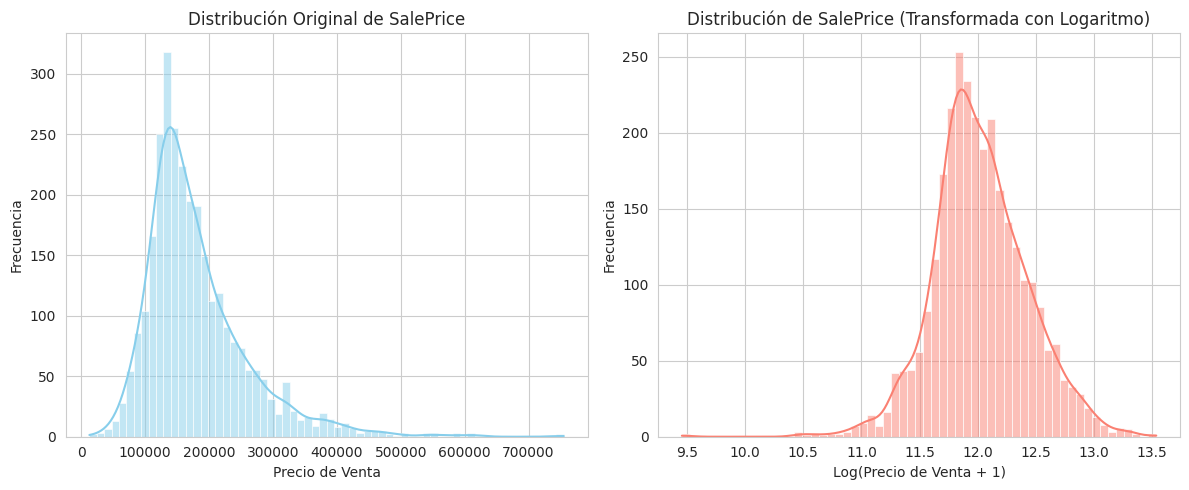

Se aplicó una transformación logarítmica a 'SalePrice' para normalizar su distribución.

--- 1.4 Identificar Tipos de Columnas y Eliminar Columnas Irrelevantes ---
Columnas eliminadas inicialmente: ['Order', 'PID', 'Alley', 'Pool QC', 'Fence', 'Misc Feature']

Encontradas 36 características numéricas. Ejemplos: ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual', 'Overall Cond']
Encontradas 39 características categóricas. Ejemplos: ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities']

--- 1.5 Análisis de Valores Faltantes ---
Columnas con valores faltantes y la cantidad:


,Cantidad Faltante
Mas Vnr Type,1775
Fireplace Qu,1422
Lot Frontage,490
Garage Finish,159
Garage Yr Blt,159
Garage Cond,159
Garage Qual,159
Garage Type,157
Bsmt Exposure,83
BsmtFin Type 2,81


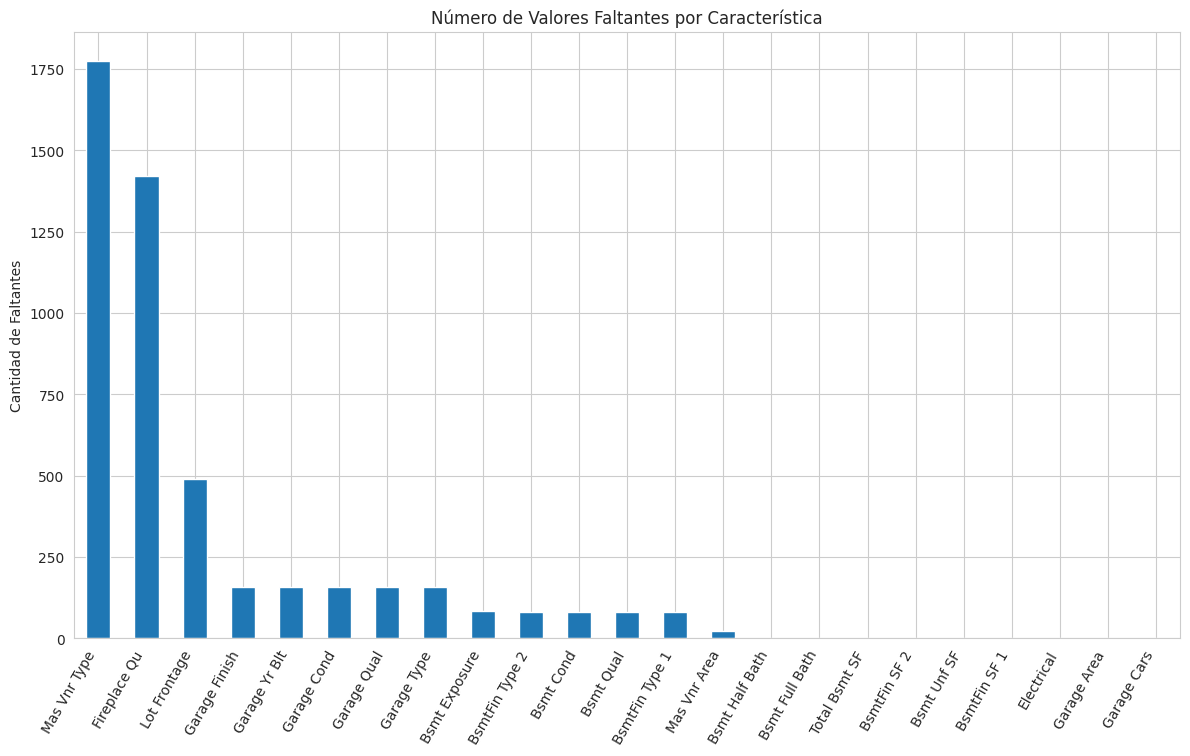


--- 1.6 Visualizaciones Estadísticas (EDA Visual) ---
Generando gráficos... esto puede tardar un momento.

Generando Histogramas para: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Year Built', '1st Flr SF', 'Year Remod/Add', 'Garage Yr Blt', 'Full Bath']


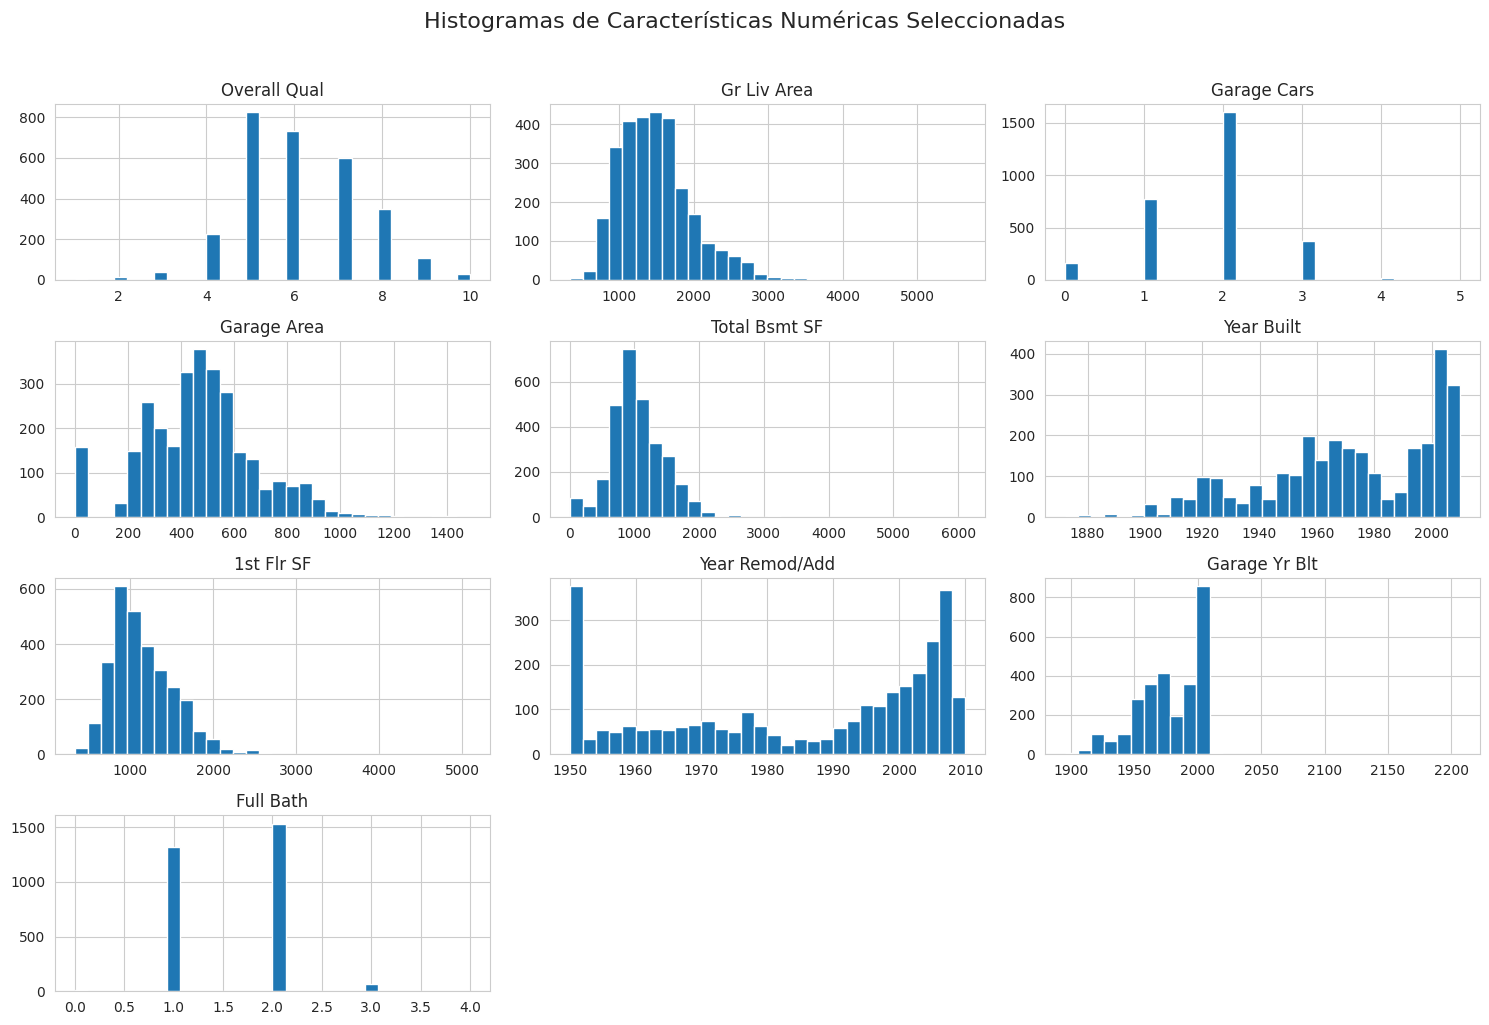


Generando Boxplots para: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Year Built', '1st Flr SF', 'Year Remod/Add', 'Garage Yr Blt', 'Full Bath']


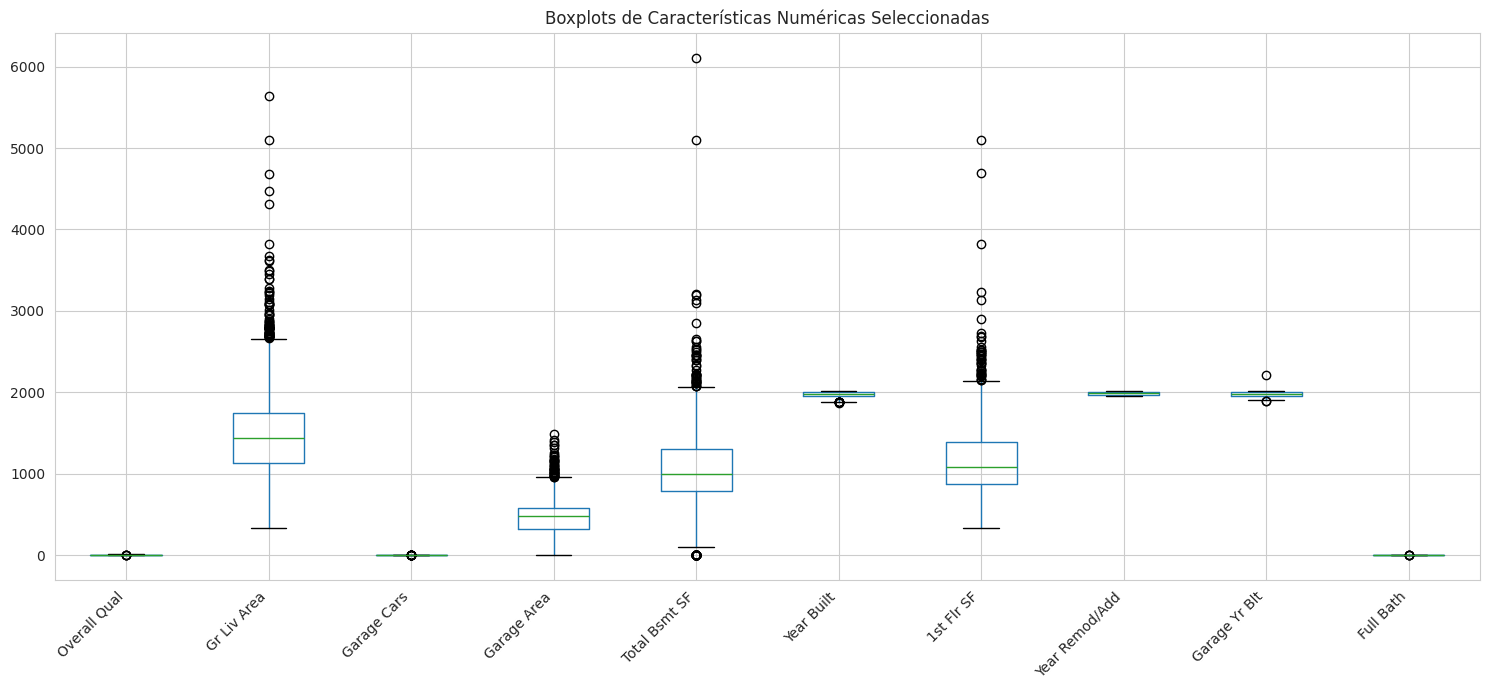


Generando Scatter Matrix para: ['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area', 'Total Bsmt SF', 'Year Built', '1st Flr SF', 'Year Remod/Add', 'Garage Yr Blt', 'Full Bath', 'SalePrice']


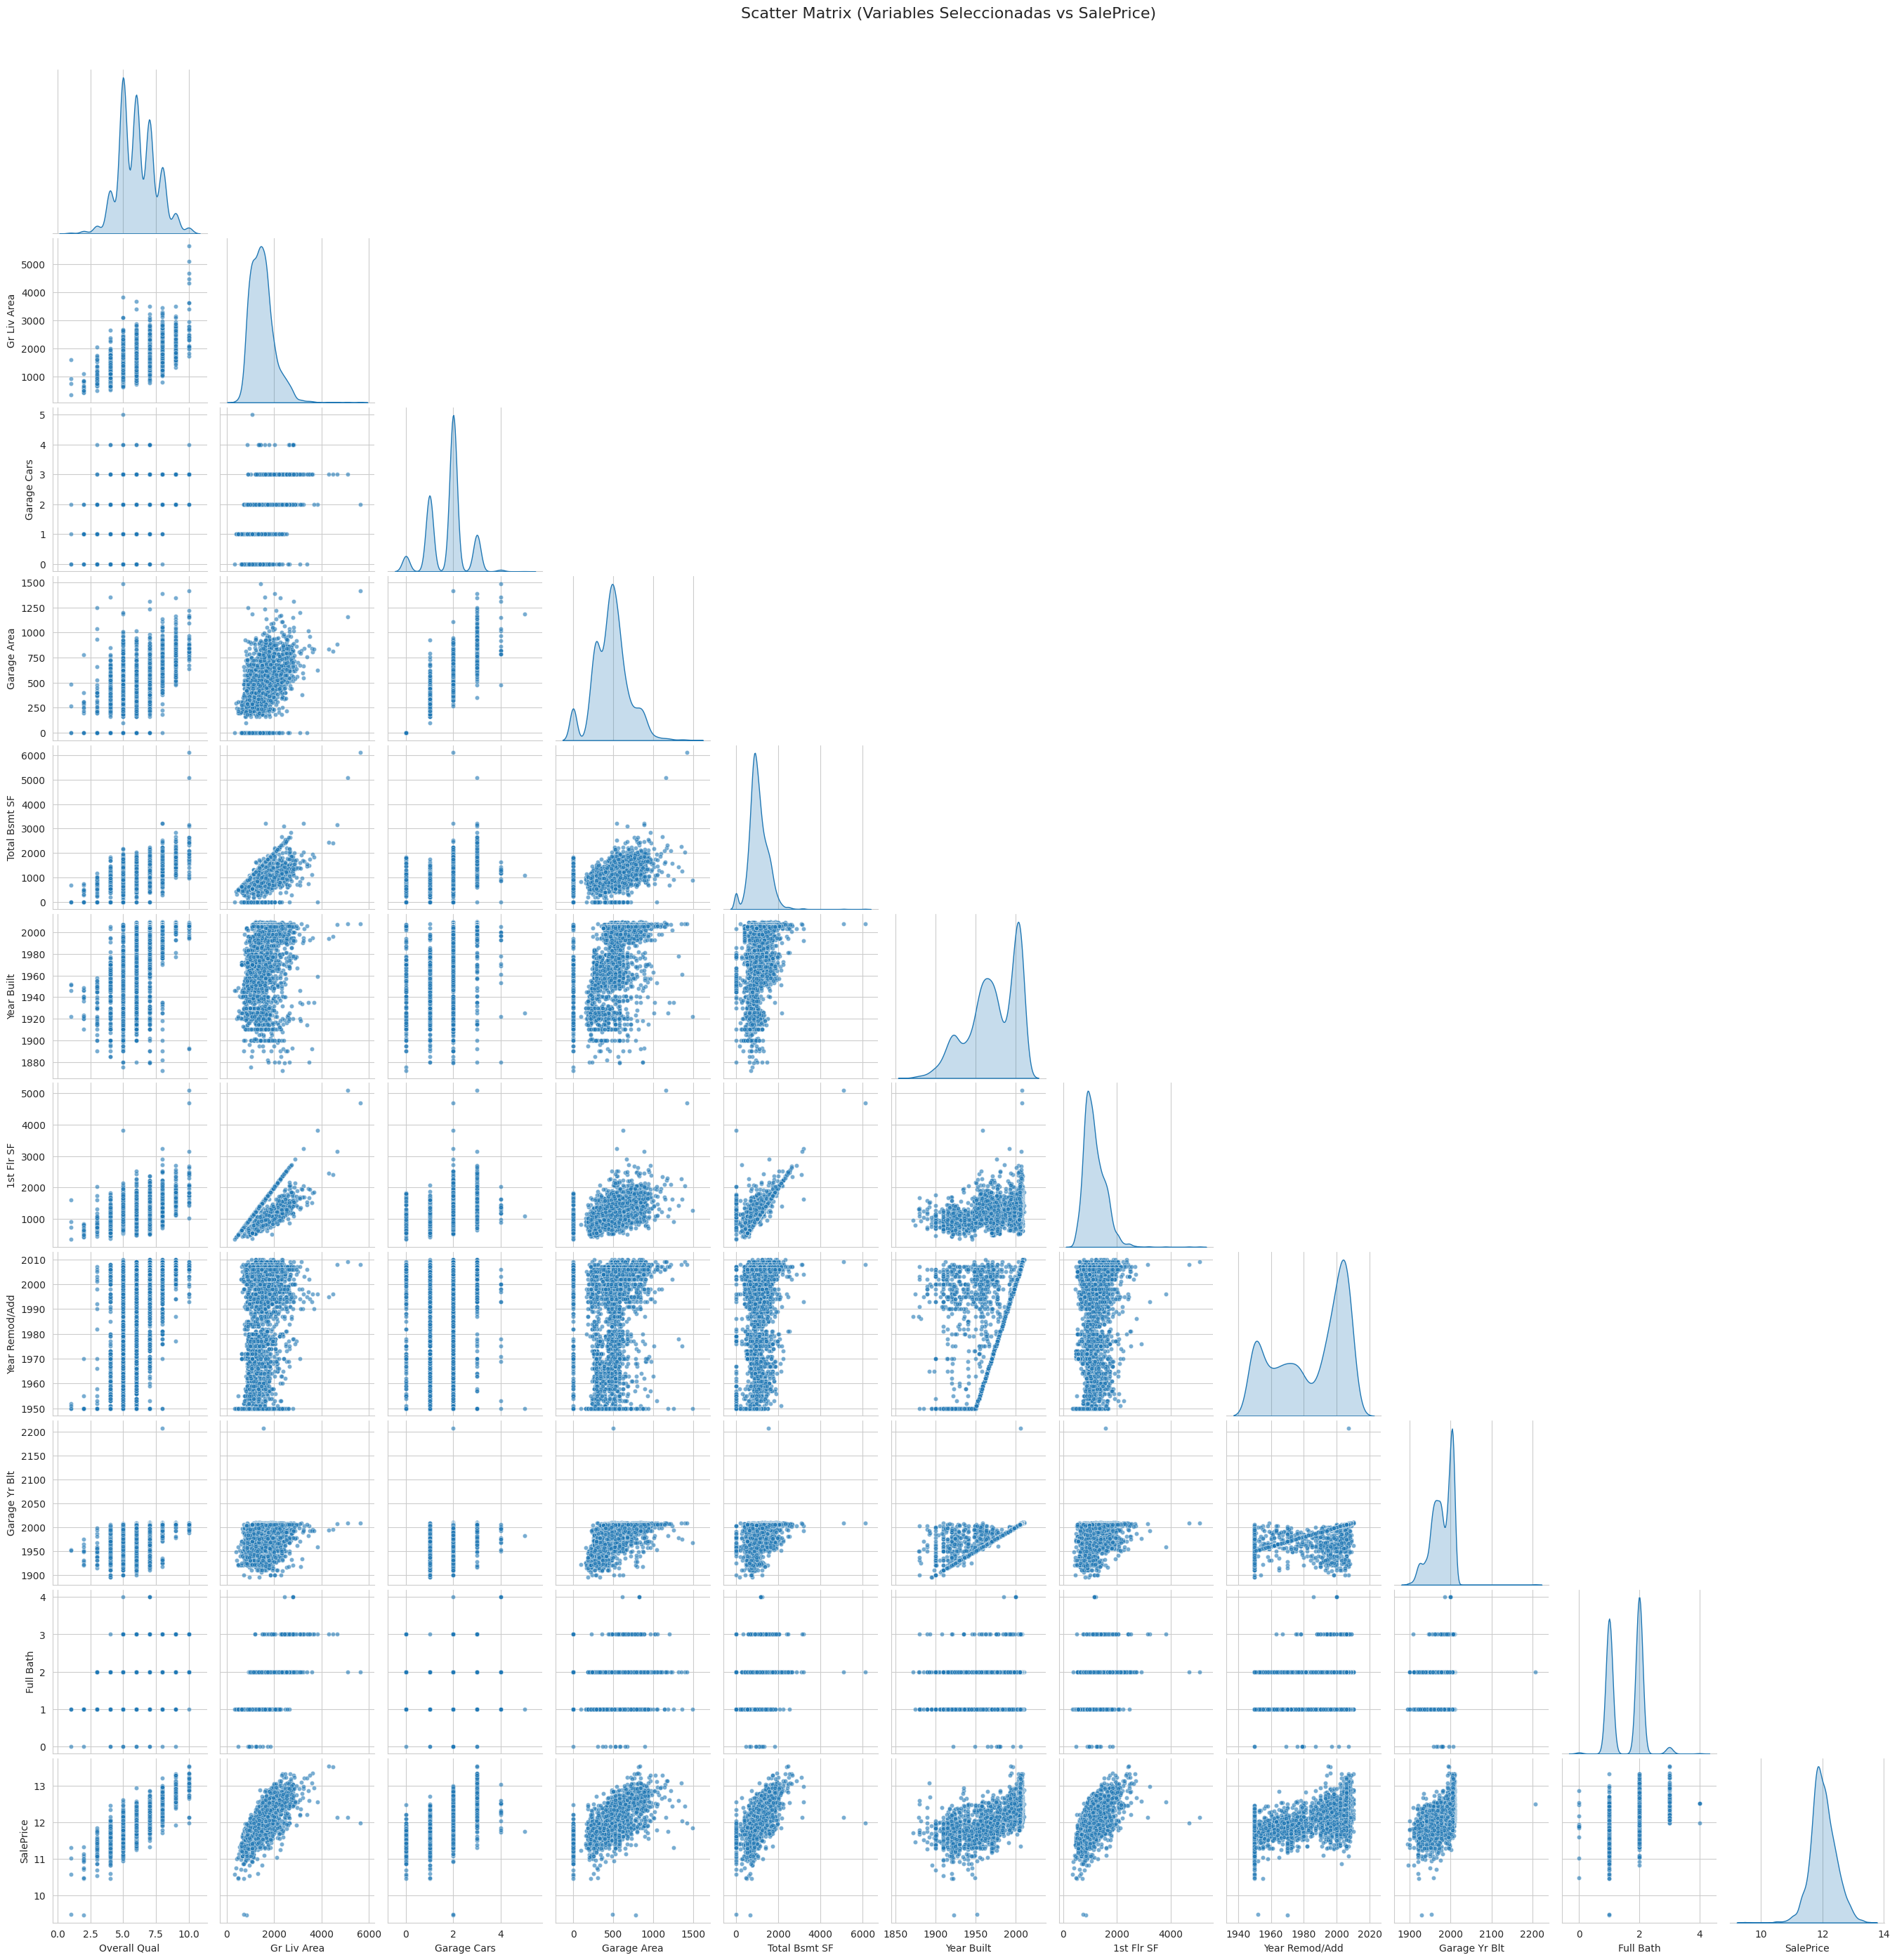


Generando Matriz de Correlación...


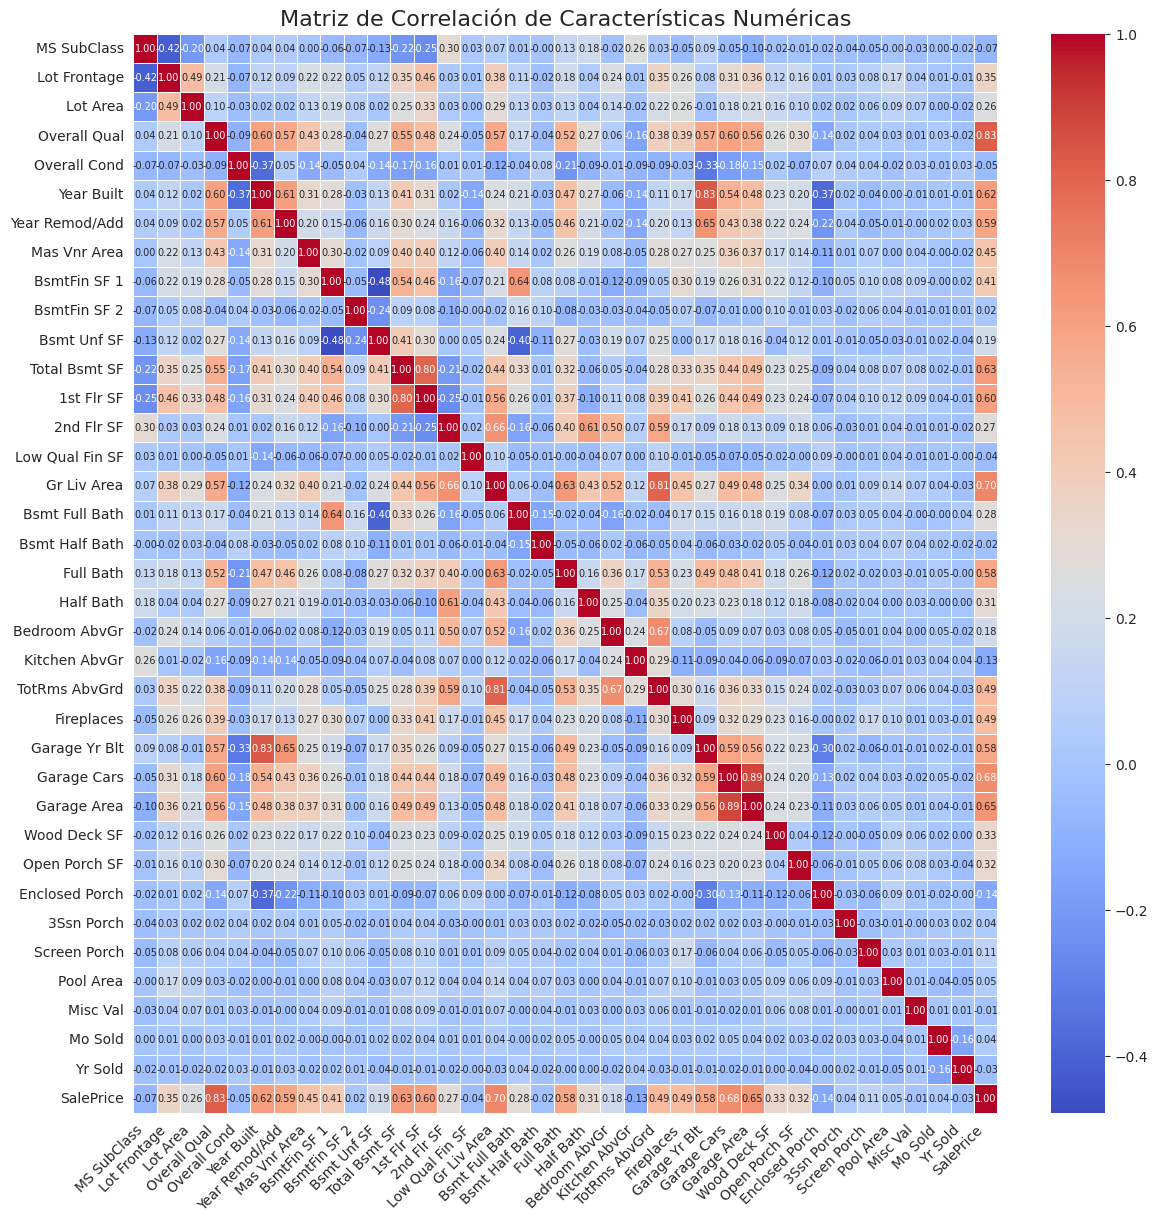


Análisis Exploratorio de Datos (EDA) completado.


In [ ]:
print("------------------------------------------------------")
print("PARTE 1: CARGA Y ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
print("------------------------------------------------------")

# --- 1.1 Cargar los Datos ---
print(f"\nCargando datos desde el archivo local: '{DATA_FILE_LOCAL}'...")
try:
    df_original = pd.read_csv(DATA_FILE_LOCAL, engine='python')
    print("¡Datos cargados exitosamente!")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{DATA_FILE_LOCAL}' en el directorio actual de Colab.")
    raise SystemExit("Deteniendo ejecución: archivo de datos no encontrado localmente.")
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")
    raise SystemExit("Deteniendo ejecución: error al leer CSV.")

df = df_original.copy()

# --- 1.2 Primera Mirada a los Datos ---
print("\n--- 1.2 Primera Mirada a los Datos ---")
print(f"El dataset tiene {df.shape[0]} filas (casas) y {df.shape[1]} columnas (características).")
print("\nPrimeras 5 filas del dataset:")
display(df.head())
print("\nInformación general del dataset (tipos de columnas, memoria):")
df.info()

# --- 1.3 Análisis de la Variable Objetivo: 'SalePrice' ---
print("\n--- 1.3 Análisis de la Variable Objetivo: 'SalePrice' ---")

# Preparamos una figura con dos subgráficos: uno para la distribución original
# y otro para la distribu­ción tras la transformación.
plt.figure(figsize=(12, 5))

# Primer subgráfico: distribución original de SalePrice
plt.subplot(1, 2, 1)
sns.histplot(df['SalePrice'], kde=True, color="skyblue")  # Histograma con KDE
plt.title('Distribución Original de SalePrice')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')

# Transformamos la variable objetivo usando log(1 + SalePrice)
# Esto reduce la asimetría (sesgo) de la distribución.
df['SalePrice'] = np.log1p(df['SalePrice'])

# Segundo subgráfico: distribución tras aplicar logaritmo
plt.subplot(1, 2, 2)
sns.histplot(df['SalePrice'], kde=True, color="salmon")
plt.title('Distribución de SalePrice (Transformada con Logaritmo)')
plt.xlabel('Log(Precio de Venta + 1)')
plt.ylabel('Frecuencia')

# Ajustamos espacios para que los títulos y ejes no se monten
plt.tight_layout()

# Mostramos la figura completa
plt.show()

print("Se aplicó una transformación logarítmica a 'SalePrice' para normalizar su distribución.")

# --- 1.4 Identificar Tipos de Columnas y Eliminar Columnas Irrelevantes ---
print("\n--- 1.4 Identificar Tipos de Columnas y Eliminar Columnas Irrelevantes ---")
cols_to_drop_initial = ['Order', 'PID', 'Alley', 'Pool QC', 'Fence', 'Misc Feature']
cols_to_drop_existing = [col for col in cols_to_drop_initial if col in df.columns]
if cols_to_drop_existing: # Solo dropear si hay algo que dropear
    df.drop(columns=cols_to_drop_existing, inplace=True)
    print(f"Columnas eliminadas inicialmente: {cols_to_drop_existing}")
else:
    print("No se encontraron columnas para eliminación inicial o ya fueron eliminadas.")


numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

categorical_features = df.select_dtypes(include='object').columns.tolist()

print(f"\nEncontradas {len(numerical_features)} características numéricas. Ejemplos: {numerical_features[:5]}")
print(f"Encontradas {len(categorical_features)} características categóricas. Ejemplos: {categorical_features[:5]}")

# --- 1.5 Análisis de Valores Faltantes ---
print("\n--- 1.5 Análisis de Valores Faltantes ---")
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Columnas con valores faltantes y la cantidad:")
if not missing_values.empty:
    display(pd.DataFrame(missing_values, columns=['Cantidad Faltante']))
    plt.figure(figsize=(12, max(5, len(missing_values) / 3)))
    missing_values.plot(kind='bar')
    plt.title('Número de Valores Faltantes por Característica')
    plt.ylabel('Cantidad de Faltantes')
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("¡Genial! No hay valores faltantes después de la limpieza inicial.")

# --- 1.6 Visualizaciones Estadísticas (EDA Visual) ---
print("\n--- 1.6 Visualizaciones Estadísticas (EDA Visual) ---")
print("Generando gráficos... esto puede tardar un momento.")

# Creamos una copia de df para asegurar que 'SalePrice' esté presente para el cálculo de correlación
df_for_corr = df.copy()
if 'SalePrice' not in df_for_corr.columns and 'SalePrice' in df.columns: # Si se dropeó por error antes
    df_for_corr['SalePrice'] = df['SalePrice']

# Recalcular numerical_features_from_df por si df cambió
numerical_features_from_df = df_for_corr.select_dtypes(include=np.number).columns.tolist()
if 'SalePrice' in numerical_features_from_df: # Quitar SalePrice de features si está
    numerical_features_from_df.remove('SalePrice')

if len(numerical_features_from_df) > 0 and 'SalePrice' in df_for_corr.columns:
    correlations_with_target = df_for_corr[numerical_features_from_df + ['SalePrice']].corr()['SalePrice'].abs().sort_values(ascending=False)
    top_n_corr = min(10, len(numerical_features_from_df))
    # Excluir SalePrice misma si está en los índices (el primer elemento es SalePrice con correlación 1.0)
    numerical_features_for_eda_plots = correlations_with_target.index[1:top_n_corr+1].tolist()
    if not numerical_features_for_eda_plots and numerical_features_from_df :
        numerical_features_for_eda_plots = numerical_features_from_df[:min(5, len(numerical_features_from_df))]
elif len(numerical_features_from_df) > 0: # Si no hay SalePrice pero sí features numéricas
    numerical_features_for_eda_plots = numerical_features_from_df[:min(10, len(numerical_features_from_df))]
else:
    numerical_features_for_eda_plots = []


if numerical_features_for_eda_plots:
    print(f"\nGenerando Histogramas para: {numerical_features_for_eda_plots}")
    df[numerical_features_for_eda_plots].hist(bins=30, figsize=(15, 10), layout=(-1, 3))
    plt.suptitle("Histogramas de Características Numéricas Seleccionadas", y=1.02, size=16)
    plt.tight_layout()
    plt.show()

    print(f"\nGenerando Boxplots para: {numerical_features_for_eda_plots}")
    plt.figure(figsize=(15, 7))
    df.boxplot(column=numerical_features_for_eda_plots)
    plt.title('Boxplots de Características Numéricas Seleccionadas')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Solo generar scatter matrix si SalePrice está en df
    if 'SalePrice' in df.columns:
        print(f"\nGenerando Scatter Matrix para: {numerical_features_for_eda_plots + ['SalePrice']}")
        scatter_subset_cols = [col for col in numerical_features_for_eda_plots + ['SalePrice'] if col in df.columns]
        scatter_subset = df[scatter_subset_cols]
        if not scatter_subset.empty:
            sns.pairplot(scatter_subset, diag_kind='kde', corner=True, plot_kws={'alpha':0.6, 's':20}, diag_kws={'fill':True})
            plt.suptitle("Scatter Matrix (Variables Seleccionadas vs SalePrice)", y=1.02, size=16)
            plt.show()
        else:
            print("No hay datos suficientes o columnas válidas para el scatter matrix.")

else:
    print("No hay suficientes características numéricas seleccionadas para generar EDA plots detallados.")

# Re-obtener lista de numéricas (sin SalePrice) de df actual para la matriz de correlación
numerical_features_current = df.select_dtypes(include=np.number).columns.tolist()
if 'SalePrice' in numerical_features_current:
    numerical_features_current.remove('SalePrice')

if len(numerical_features_current) > 0 and 'SalePrice' in df.columns:
    print("\nGenerando Matriz de Correlación...")
    # Incluir SalePrice para ver sus correlaciones con las features
    cols_for_corr_matrix = numerical_features_current + ['SalePrice']
    # Asegurarse que todas las columnas existan en df
    cols_for_corr_matrix = [col for col in cols_for_corr_matrix if col in df.columns]

    correlation_matrix = df[cols_for_corr_matrix].corr()
    plt.figure(figsize=(max(12, len(cols_for_corr_matrix)/3.0), max(10, len(cols_for_corr_matrix)/3.0))) # Ajustar dinámicamente
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 7}) # Tamaño de annot más pequeño
    plt.title('Matriz de Correlación de Características Numéricas', size=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes características numéricas o SalePrice no está disponible para la matriz de correlación.")

print("\nAnálisis Exploratorio de Datos (EDA) completado.")

## PARTE 2: Preprocesamiento de Datos

Preparar los datos para que los modelos de Machine Learning puedan entenderlos y aprender de ellos.

In [ ]:
print("\n------------------------------------------------------")
print("PARTE 2: PREPROCESAMIENTO DE DATOS")
print("------------------------------------------------------")

# Separar X e y A PARTIR DE ESTE PUNTO para evitar que futuras modificaciones a X afecten al df original
# df ya tiene SalePrice transformado y algunas columnas dropeadas
if 'SalePrice' not in df.columns:
    raise ValueError("La columna 'SalePrice' no se encuentra en el DataFrame 'df'. Verifica los pasos anteriores.")

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# --- 2.1 Mapeo Ordinal y Agrupación de Categorías Raras ---
print("\n--- 2.1 Definiendo Mapeos Ordinales y Agrupación de Categorías Raras ---")

ordinal_mapping_quality = {'Missing': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
quality_cols_map = {
    'Exter Qual': ordinal_mapping_quality, 'Exter Cond': ordinal_mapping_quality,
    'Bsmt Qual': ordinal_mapping_quality, 'Bsmt Cond': ordinal_mapping_quality,
    'Heating QC': ordinal_mapping_quality, 'Kitchen Qual': ordinal_mapping_quality,
    'Fireplace Qu': ordinal_mapping_quality, 'Garage Qual': ordinal_mapping_quality,
    'Garage Cond': ordinal_mapping_quality,
}
functional_map = {'Missing':0, 'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}
quality_cols_map['Functional'] = functional_map

ordinal_general_mappings = {
    'Lot Shape': {'Missing': 0, 'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
    'Utilities': {'Missing': 0, 'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}, # Utilities es casi constante, podría dropearse.
    'Land Slope': {'Missing': 0, 'Sev': 1, 'Mod': 2, 'Gtl': 3},
    'Bsmt Exposure': {'Missing': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFin Type 1': {'Missing': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFin Type 2': {'Missing': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'Garage Finish': {'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'Paved Drive': {'Missing': 0, 'N': 1, 'P': 2, 'Y': 3},
}
all_ordinal_mappings = {**quality_cols_map, **ordinal_general_mappings}

# Identificar columnas categóricas originales directamente de X
categorical_features_in_X = X.select_dtypes(include='object').columns.tolist()

ordinal_features_for_ct = [col for col in categorical_features_in_X if col in all_ordinal_mappings.keys()]
nominal_features_for_ct = [col for col in categorical_features_in_X if col not in ordinal_features_for_ct]

print(f"Características ordinales para CT ({len(ordinal_features_for_ct)}): {ordinal_features_for_ct[:5]}...")
print(f"Características nominales para CT ({len(nominal_features_for_ct)}): {nominal_features_for_ct[:5]}...")

# Agrupación de categorías raras directamente en X (que es una copia de df sin SalePrice)
print("\nAgrupando categorías raras en variables nominales (si aplica)...")
for col in nominal_features_for_ct:
    # Aplicar solo a las de alta cardinalidad o si tienen muchas categorías
    unique_count = X[col].nunique()
    if unique_count > 10: # Umbral para considerar "alta cardinalidad" para este propósito
        frequencies = X[col].value_counts(normalize=True)
        # Considerar rara una categoría si aparece en menos del 1% de las filas O si hay más de 20 categorías
        rare_threshold = 0.01
        rare_categories = frequencies[frequencies < rare_threshold].index
        if len(rare_categories) > 0:
            # Hacer una copia de la columna para modificarla y reasignarla
            # Esto evita SettingWithCopyWarning si X fuera una vista
            col_copy = X[col].copy()
            col_copy.replace(rare_categories, 'Rare_Category', inplace=True)
            X[col] = col_copy
            print(f"  En '{col}', se agruparon {len(rare_categories)} categorías como 'Rare_Category'.")


# --- 2.2 Creación de Pipelines de Preprocesamiento ---
print("\n--- 2.2 Creando Pipelines de Preprocesamiento ---")
# Obtener columnas numéricas directamente de X (que ya no tiene SalePrice)
numerical_features_in_X = X.select_dtypes(include=np.number).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) # O StandardScaler()
])
print("Pipeline para numéricas: Imputación con mediana + RobustScaler.")

# Construir la lista de categorías para el OrdinalEncoder dinámicamente
ordinal_encoder_categories_list = []
valid_ordinal_cols_for_encoder = [] # Columnas que realmente usarán OrdinalEncoder

# Verificar que las columnas ordinales existan en X y tengan mapeos
temp_nominal_add = [] # Para columnas que se suponían ordinales pero no tienen mapping
for col in ordinal_features_for_ct:
    if col in X.columns and col in all_ordinal_mappings:
        # Obtener las categorías del mapping en el orden correcto
        # Asegurarse que 'Missing' esté si se usa como fill_value
        current_mapping_keys = list(all_ordinal_mappings[col].keys())
        if 'Missing' not in current_mapping_keys:
             # Si 'Missing' es el fill_value y no está en el mapping, OrdinalEncoder podría fallar
             # Asumimos que 'Missing' como clave en el mapping es la forma correcta de manejarlo
             # Esto ya está cubierto por la estructura de all_ordinal_mappings
             pass
        ordinal_encoder_categories_list.append(current_mapping_keys)
        valid_ordinal_cols_for_encoder.append(col)
    elif col in X.columns: # Existe pero no tiene mapping
        print(f"Advertencia: No se encontró mapeo para la columna '{col}'. Será tratada como nominal.")
        temp_nominal_add.append(col)

# Actualizar listas
ordinal_features_for_ct = valid_ordinal_cols_for_encoder
nominal_features_for_ct.extend(temp_nominal_add)
nominal_features_for_ct = sorted(list(set(nominal_features_for_ct))) # Unicas y ordenadas


if ordinal_features_for_ct: # Solo crear si hay columnas ordinales válidas
    ordinal_transformer_ct = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')), # 'Missing' DEBE ser una categoría conocida por OrdinalEncoder
        ('ordinal', OrdinalEncoder(categories=ordinal_encoder_categories_list,
                                   handle_unknown='use_encoded_value', unknown_value=-1)) # -1 para NaNs o desconocidos
    ])
    print("Pipeline para ordinales (dentro de CT): Imputación con 'Missing' + OrdinalEncoder.")
else:
    ordinal_transformer_ct = 'drop' # Si no hay, se puede dropear o pasar un transformador vacío
    print("No hay características ordinales válidas para el OrdinalEncoder.")


nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing_Nominal')), # Usar un fill_value distinto
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')) # drop='first' para reducir colinealidad
])
print("Pipeline para nominales: Imputación con constante + OneHotEncoder (drop='first').")


# --- 2.3 Ensamblando el Preprocesador Principal con ColumnTransformer ---
print("\n--- 2.3 Ensamblando el Preprocesador Principal (ColumnTransformer) ---")

transformers_list = []
if numerical_features_in_X:
    transformers_list.append(('num', numerical_transformer, numerical_features_in_X))
if ordinal_features_for_ct and ordinal_transformer_ct != 'drop':
    transformers_list.append(('ord', ordinal_transformer_ct, ordinal_features_for_ct))
if nominal_features_for_ct:
    transformers_list.append(('nom', nominal_transformer, nominal_features_for_ct))

if not transformers_list:
    print("ERROR: No hay transformadores para construir el ColumnTransformer. Revisa las listas de features.")
    # Considerar detener la ejecución o manejar este caso
else:
    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='drop', # 'drop' para eliminar columnas no especificadas
        n_jobs=-1 # Usar todos los procesadores disponibles
    )
    print("ColumnTransformer ensamblado.")


# --- 2.4 Dividir Datos en Entrenamiento y Prueba ---
# Usamos el X modificado (con categorías raras agrupadas)
print("\n--- 2.4 Dividiendo Datos en Entrenamiento y Prueba ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}, y_test: {y_test.shape}")
print("\nPreprocesamiento configurado y datos divididos.")

# Probar el preprocesador en X_train para ver la forma de salida (opcional, para depuración)
try:
    X_train_transformed_shape = preprocessor.fit_transform(X_train).shape
    print(f"Forma de X_train después del preprocesamiento: {X_train_transformed_shape}")
except Exception as e_preproc_test:
    print(f"Error al probar el preprocesador en X_train: {e_preproc_test}")
    print("Esto puede indicar un problema en la configuración del ColumnTransformer o los pipelines internos.")


------------------------------------------------------
PARTE 2: PREPROCESAMIENTO DE DATOS
------------------------------------------------------

--- 2.1 Definiendo Mapeos Ordinales y Agrupación de Categorías Raras ---
Características ordinales para CT (18): ['Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond']...
Características nominales para CT (21): ['MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood']...

Agrupando categorías raras en variables nominales (si aplica)...
  En 'Neighborhood', se agruparon 7 categorías como 'Rare_Category'.
  En 'Exterior 1st', se agruparon 6 categorías como 'Rare_Category'.
  En 'Exterior 2nd', se agruparon 7 categorías como 'Rare_Category'.

--- 2.2 Creando Pipelines de Preprocesamiento ---
Pipeline para numéricas: Imputación con mediana + RobustScaler.
Pipeline para ordinales (dentro de CT): Imputación con 'Missing' + OrdinalEncoder.
Pipeline para nominales: Imputación con constante + OneHotEncoder (drop='first').

-

## PARTE 3: Definición de Modelos, Parámetros y Estrategia de Búsqueda

Configurar los modelos que probaremos y cómo encontraremos sus mejores "ajustes" (hiperparámetros).

In [ ]:
print("\n---------------------------------------------------------------------")
print("PARTE 3: MODELOS, HIPERPARÁMETROS Y ESTRATEGIA DE BÚSQUEDA")
print("---------------------------------------------------------------------")

# --- 3.1 Sistema de Caché ---
CACHE_DIR_COLAB = "/content/ames_cache_colab"

def get_cache_filename_colab(model_name, search_type, target_var_name="SalePrice"):
    os.makedirs(CACHE_DIR_COLAB, exist_ok=True)
    # El random_state del split y test_size podrían incluirse si se varían mucho
    # pero para este ejercicio, asumimos que son fijos para cada corrida de caché.
    filename = f"{model_name}_{search_type}_{target_var_name}.joblib"
    return os.path.join(CACHE_DIR_COLAB, filename)

def save_to_cache_colab(data_to_save, model_name, search_type):
    filename = get_cache_filename_colab(model_name, search_type)
    try:
        joblib.dump(data_to_save, filename)
        print(f"  Resultados para '{model_name}' ({search_type}) guardados en caché: {filename}")
    except Exception as e:
        print(f"  ERROR guardando caché para {model_name} ({search_type}): {e}")

def load_from_cache_colab(model_name, search_type):
    filename = get_cache_filename_colab(model_name, search_type)
    if os.path.exists(filename):
        try:
            print(f"  Cargando resultados para '{model_name}' ({search_type}) desde caché: {filename}")
            return joblib.load(filename)
        except Exception as e:
            print(f"  ERROR cargando caché {filename}: {e}. Se recomputará.")
            # Considerar eliminar el archivo de caché corrupto
            # os.remove(filename)
            return None
    return None
print("Sistema de caché para Colab configurado.")


# --- 3.2 Definición de Modelos y Espacios de Parámetros ---
print("\n--- 3.2 Definiendo Modelos y sus Espacios de Hiperparámetros ---")

# Número de particiones internas para el tuning (GridSearch, RandomizedSearch, etc.):
CV_FOLDS_TUNING = 3
# Creamos un objeto KFold para reusar en todos los modelos:
# - n_splits: cuántas particiones
# - shuffle: barajar antes de dividir (evita sesgos por orden de datos)
# - random_state: semilla fija para reproducibilidad
kf_tuning = KFold(n_splits=CV_FOLDS_TUNING, shuffle=True, random_state=42)

# Métrica a optimizar: el negativo del MSE (scikit-learn maximiza, por eso 'neg_')
SCORING_METRIC_TUNING = 'neg_mean_squared_error'


# --------------------------------------------------
# Configuración de cada modelo y sus rangos de search
# --------------------------------------------------
models_config_colab = {

    # 1) Regresión lineal ordinaria (baseline sin regularización)
    'LinearRegression': {
        'model': LinearRegression(),
        'grid_params': {},      # Sin hiperparámetros a ajustar
        'random_params': {},    # –
        'bayes_params': {}      # –
    },

    # 2) Lasso (regresión con penalización L1):
    #    - alpha controla la fuerza de la regularización (cero = sin penalización)
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=10000),
        'grid_params': {
            # Valores específicos para comparar exhaustivamente
            'estimator__alpha': [0.00005, 0.0001, 0.0005, 0.001]
        },
        'random_params': {
            # Búsqueda aleatoria más amplia en escala logarítmica
            'estimator__alpha': np.logspace(-5, -2, 30)
        },
        'bayes_params': {
            # Para optimización bayesiana dentro de [1e-5, 1e-2]
            'alpha': ('float', 1e-5, 1e-2, True)
        }
    },

    # 3) ElasticNet (mezcla L1 + L2):
    #    - alpha: fuerza global de regularización
    #    - l1_ratio: proporción de L1 vs. L2 (0 = puro Ridge, 1 = puro Lasso)
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=10000),
        'grid_params': {
            'estimator__alpha': [0.0005, 0.001, 0.005],
            'estimator__l1_ratio': [0.1, 0.5, 0.9]
        },
        'random_params': {
            'estimator__alpha': np.logspace(-4, -2, 20),
            'estimator__l1_ratio': np.linspace(0.05, 0.95, 10)
        },
        'bayes_params': {
            'alpha':    ('float', 1e-4, 1e-1, True),
            'l1_ratio': ('float', 0.01, 0.99, False)
        }
    },

    # 4) KernelRidge (ridge con kernel RBF):
    #    - kernel='rbf' permite capturar relaciones no lineales
    #    - gamma controla el alcance del kernel RBF
    'KernelRidge': {
        'model': KernelRidge(kernel='rbf'),
        'grid_params': {
            'estimator__alpha': [0.1, 1.0],
            'estimator__gamma': [0.05, 0.1, 0.5]
        },
        'random_params': {
            'estimator__alpha': np.logspace(-1, 1, 10),
            'estimator__gamma': np.logspace(-2, 0, 10)
        },
        'bayes_params': {
            'alpha': ('float', 1e-1, 2.0, True),
            'gamma': ('float', 1e-2, 0.5, True)
        }
    },

    # 5) SGDRegressor (descenso de gradiente estocástico):
    #    - penalty: tipo de regularización (L2 o elasticnet)
    #    - eta0 y learning_rate: controlan la tasa de aprendizaje
    'SGDRegressor': {
        'model': SGDRegressor(
            random_state=42,
            max_iter=5000,
            tol=1e-4,
            early_stopping=True,
            n_iter_no_change=20
        ),
        'grid_params': {
            'estimator__alpha':   [1e-5, 1e-4, 1e-3],
            'estimator__penalty': ['l2', 'elasticnet']
        },
        'random_params': {
            'estimator__alpha':      np.logspace(-5, -2, 20),
            'estimator__penalty':    ['l2', 'elasticnet'],
            'estimator__learning_rate': ['optimal', 'adaptive'],
            'estimator__eta0':       [0.001, 0.01, 0.05]
        },
        'bayes_params': {
            'alpha':         ('float', 1e-5, 1e-2, True),
            'penalty':       ('categorical', ['l2', 'elasticnet']),
            'eta0':          ('float', 1e-3, 1e-1, True),
            'learning_rate': ('categorical', ['optimal', 'adaptive'])
        }
    },

    # 6) BayesianRidge (regresión bayesiana):
    #    - alpha_1, alpha_2, lambda_1, lambda_2: hiperparámetros de prior del modelo bayesiano
    'BayesianRidge': {
        'model': BayesianRidge(),
        'grid_params': {
            'estimator__alpha_1':  [1e-7, 1e-6, 1e-5],
            'estimator__lambda_1': [1e-7, 1e-6, 1e-5]
        },
        'random_params': {
            'estimator__alpha_1':  np.logspace(-7, -5, 10),
            'estimator__alpha_2':  np.logspace(-7, -5, 10),
            'estimator__lambda_1': np.logspace(-7, -5, 10),
            'estimator__lambda_2': np.logspace(-7, -5, 10)
        },
        'bayes_params': {
            'alpha_1':  ('float', 1e-7, 1e-5, True),
            'alpha_2':  ('float', 1e-7, 1e-5, True),
            'lambda_1': ('float', 1e-7, 1e-5, True),
            'lambda_2': ('float', 1e-7, 1e-5, True)
        }
    },

    # 7) RandomForestRegressor (modelo de ensamble basado en árboles):
    #    - n_estimators: número de árboles en el bosque
    #    - max_depth, min_samples_split/leaf: control de complejidad de cada árbol
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'grid_params': {
            'estimator__n_estimators':    [100, 150],
            'estimator__max_depth':       [10, 25, None],
            'estimator__min_samples_split': [2, 6],
            'estimator__min_samples_leaf':  [1, 4]
        },
        'random_params': {
            'estimator__n_estimators':    [int(x) for x in np.linspace(80, 250, 5)],
            'estimator__max_depth':       [None] + [int(x) for x in np.linspace(10, 40, 3)],
            'estimator__min_samples_split': [2, 5, 10],
            'estimator__min_samples_leaf':  [1, 3, 6]
        },
        'bayes_params': {
            'n_estimators':      ('int', 80, 300),
            'max_depth':         ('int_or_none', 10, 50),
            'min_samples_split': ('int', 2, 12),
            'min_samples_leaf':  ('int', 1, 10)
        }
    },

    # 8) SVR (Support Vector Regression) con kernel RBF:
    #    - C: peso de la penalización de errores
    #    - gamma: alcance del kernel RBF
    #    - epsilon: margen de tolerancia para el error
    'SVR': {
        'model': SVR(kernel='rbf', cache_size=700),
        'grid_params': {
            'estimator__C':       [1, 10, 50],
            'estimator__gamma':   ['scale', 0.01, 0.1],
            'estimator__epsilon': [0.05, 0.1, 0.2]
        },
        'random_params': {
            'estimator__C':       np.logspace(0, 2, 10),
            'estimator__gamma':   np.logspace(-3, 0, 10),
            'estimator__epsilon': np.logspace(-2, -0.5, 10)
        },
        'bayes_params': {
            'C':       ('float', 0.5, 100.0, True),
            'gamma':   ('float', 1e-3, 0.5, True),
            'epsilon': ('float', 1e-2, 0.5, True)
        }
    },

    # 9) GaussianProcessRegressor (modelo no paramétrico basado en procesos gaussianos):
    #    - Kernel compuesto: C(1.0)*RBF(1.0) + WhiteKernel(0.1)
    #      • RBF: capta relaciones suaves y continuas.
    #      • WhiteKernel: modela ruido aleatorio.
    #    - n_restarts_optimizer=1 para limitar tiempo de optimización en Colab.
    'GaussianProcessRegressor': {
        'model': GaussianProcessRegressor(
            kernel=C(1.0) * RBF(1.0) + WhiteKernel(0.1),
            random_state=42,
            normalize_y=False,
            n_restarts_optimizer=1
        ),
        'grid_params': {
            'estimator__alpha': [0.1, 0.5, 1.0]
        },
        'random_params': {
            'estimator__alpha': np.logspace(-1, 0.5, 5)
        },
        'bayes_params': {
            'alpha': ('float', 1e-1, 1.5, False)
        }
    }
}

print(f"Configuración de {len(models_config_colab)} modelos y sus hiperparámetros lista.")
print("Modelos a probar:", list(models_config_colab.keys()))


---------------------------------------------------------------------
PARTE 3: MODELOS, HIPERPARÁMETROS Y ESTRATEGIA DE BÚSQUEDA
---------------------------------------------------------------------
Sistema de caché para Colab configurado.

--- 3.2 Definiendo Modelos y sus Espacios de Hiperparámetros ---
Configuración de 9 modelos y sus hiperparámetros lista.
Modelos a probar: ['LinearRegression', 'Lasso', 'ElasticNet', 'KernelRidge', 'SGDRegressor', 'BayesianRidge', 'RandomForestRegressor', 'SVR', 'GaussianProcessRegressor']


## PARTE 4: Entrenamiento, Búsqueda de Hiperparámetros y Evaluación

Probaremos cada modelo y encontraremos la mejor configuración para él.**Nota:** Esta celda tarda entre 40 minutos y una hora en ejecutarse, especialmente la primera vez sin caché, incluso con los parámetros reducidos para Colab. Se adjuntan los archivos caché para mejorar la velocidad.

In [ ]:
print("\n---------------------------------------------------------------------")
print("PARTE 4: ENTRENAMIENTO, TUNING Y EVALUACIÓN CON VALIDACIÓN CRUZADA")
print("---------------------------------------------------------------------")

N_ITER_RANDOM_SEARCH = 8  # Reducido aún más para Colab
N_TRIALS_BAYESIAN_OPT = 8 # Reducido aún más para Colab. Para GPR, se reduce más internamente.

all_cv_results_colab = []
CV_FOLDS_EVALUATION = 5 # Según lo que se pide en el punto 2 del parcial.
kf_evaluation = KFold(n_splits=CV_FOLDS_EVALUATION, shuffle=True, random_state=123)

def mean_absolute_percentage_error_custom(y_true_orig, y_pred_orig):
    y_true_orig, y_pred_orig = np.array(y_true_orig), np.array(y_pred_orig)
    mask = y_true_orig != 0
    if not np.any(mask): return 0.0
    # Evitar valores MAPE extremadamente grandes si y_pred_orig es muy diferente y y_true_orig es pequeño
    # Esto es una heurística, podrías necesitar un manejo más robusto de outliers en MAPE
    # percentage_diff = np.abs((y_true_orig[mask] - y_pred_orig[mask]) / y_true_orig[mask])
    # return np.mean(np.clip(percentage_diff, 0, 5)) * 100 # Clip al 500% de error
    return np.mean(np.abs((y_true_orig[mask] - y_pred_orig[mask]) / y_true_orig[mask])) * 100


# Bucle principal sobre cada modelo configurado
for model_name, config in models_config_colab.items():
    print(f"\n\n===== PROCESANDO MODELO: {model_name} =====")
    base_model_instance = config['model']

    # Asegurarse de que 'preprocessor' esté definido y sea usable
    if 'preprocessor' not in globals() or preprocessor is None:
        print("ERROR: El objeto 'preprocessor' no está definido. Ejecuta la celda de preprocesamiento.")
        break # Salir del bucle si el preprocesador no existe

    full_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', base_model_instance)])
    best_estimators_for_model = {}

    # --- 1. GridSearchCV ---
    search_method = 'GridSearch'
    print(f"\n--- {search_method} para {model_name} ---")
    if config['grid_params']:
        cached_gs = load_from_cache_colab(model_name, search_method)
        if cached_gs and 'best_estimator' in cached_gs and 'best_params' in cached_gs :
            best_estimator_gs = cached_gs['best_estimator']
            # Es importante que el estimador cargado esté ajustado o sea un objeto de búsqueda ajustado
            # Si es un objeto de búsqueda, extraer .best_estimator_
            if hasattr(best_estimator_gs, 'best_estimator_'):
                 best_estimator_gs = best_estimator_gs.best_estimator_
            print(f"  Mejores hiperparámetros (GridSearchCV) desde caché: {cached_gs['best_params']}")
        else:
            start_time_gs = time.time()
            gs_cv = GridSearchCV(full_pipeline, config['grid_params'], cv=kf_tuning,
                                 scoring=SCORING_METRIC_TUNING, n_jobs=-1, verbose=0)
            try:
                gs_cv.fit(X_train, y_train)
                best_estimator_gs = gs_cv.best_estimator_
                print(f"  Mejores hiperparámetros (GridSearchCV): {gs_cv.best_params_}")
                # Guardar el objeto de búsqueda completo para poder acceder a más info si es necesario
                save_to_cache_colab({'best_estimator': gs_cv, 'best_params': gs_cv.best_params_}, model_name, search_method)
            except Exception as e:
                print(f"  ERROR en GridSearchCV para {model_name}: {e}")
                best_estimator_gs = None
            print(f"  GridSearchCV para {model_name} tomó {time.time() - start_time_gs:.2f} seg.")
        best_estimators_for_model[search_method] = best_estimator_gs
    else:
        print(f"  {model_name} no tiene parámetros para GridSearchCV. Usando modelo base.")
        # Entrenar el pipeline base y guardarlo
        # Clona para asegurar que no se modifica el original si se reusa
        base_pipeline_fitted = clone(full_pipeline).fit(X_train, y_train)
        best_estimators_for_model[search_method] = base_pipeline_fitted


    # --- 2. RandomizedSearchCV ---
    search_method = 'RandomSearch'
    print(f"\n--- {search_method} para {model_name} ---")
    if config['random_params']:
        current_n_iter = N_ITER_RANDOM_SEARCH
        if model_name == 'GaussianProcessRegressor': current_n_iter = max(1, N_ITER_RANDOM_SEARCH // 2) # Aún menos para GPR

        cached_rs = load_from_cache_colab(model_name, search_method)
        if cached_rs and 'best_estimator' in cached_rs and 'best_params' in cached_rs:
            best_estimator_rs = cached_rs['best_estimator']
            if hasattr(best_estimator_rs, 'best_estimator_'):
                 best_estimator_rs = best_estimator_rs.best_estimator_
            print(f"  Mejores hiperparámetros (RandomizedSearchCV) desde caché: {cached_rs['best_params']}")
        else:
            start_time_rs = time.time()
            rs_cv = RandomizedSearchCV(full_pipeline, config['random_params'], n_iter=current_n_iter,
                                       cv=kf_tuning, scoring=SCORING_METRIC_TUNING, n_jobs=-1,
                                       random_state=42, verbose=0)
            try:
                rs_cv.fit(X_train, y_train)
                best_estimator_rs = rs_cv.best_estimator_
                print(f"  Mejores hiperparámetros (RandomizedSearchCV): {rs_cv.best_params_}")
                save_to_cache_colab({'best_estimator': rs_cv, 'best_params': rs_cv.best_params_}, model_name, search_method)
            except Exception as e:
                print(f"  ERROR en RandomizedSearchCV para {model_name}: {e}")
                best_estimator_rs = None
            print(f"  RandomizedSearchCV para {model_name} tomó {time.time() - start_time_rs:.2f} seg.")
        best_estimators_for_model[search_method] = best_estimator_rs
    else:
        print(f"  {model_name} no tiene parámetros para RandomizedSearchCV.")
        if 'GridSearch' not in best_estimators_for_model or best_estimators_for_model.get('GridSearch') is None:
             # Solo entrenar base si no se hizo para GridSearch
             base_pipeline_fitted = clone(full_pipeline).fit(X_train, y_train)
             best_estimators_for_model[search_method] = base_pipeline_fitted


    # --- 3. Bayesian Optimization (Optuna) ---
    search_method = 'BayesOpt_Optuna'
    print(f"\n--- {search_method} para {model_name} ---")
    if OPTUNA_AVAILABLE and config['bayes_params']:
        current_n_trials = N_TRIALS_BAYESIAN_OPT
        if model_name == 'GaussianProcessRegressor': current_n_trials = max(1, N_TRIALS_BAYESIAN_OPT // 2) # Aún menos para GPR

        cached_bo = load_from_cache_colab(model_name, search_method)
        if cached_bo and 'best_estimator' in cached_bo and 'best_params_display' in cached_bo:
            best_estimator_bo = cached_bo['best_estimator'] # Este ya debería ser un pipeline ajustado
            best_params_bo_display = cached_bo['best_params_display']
            print(f"  Mejores hiperparámetros (Optuna) desde caché: {best_params_bo_display}")
        else:
            start_time_bo = time.time()

            def objective_optuna_colab(trial):
                params_to_set = {}
                current_config_bayes_params = models_config_colab[model_name]['bayes_params'] # Acceder a la config del modelo actual

                for param_name, definition in current_config_bayes_params.items():
                    param_type = definition[0]
                    pipeline_param_name = f'estimator__{param_name}'

                    if param_type == 'float':
                        _, low, high, is_log = definition
                        params_to_set[pipeline_param_name] = trial.suggest_float(param_name, low, high, log=is_log)
                    elif param_type == 'int':
                        _, low, high = definition
                        params_to_set[pipeline_param_name] = trial.suggest_int(param_name, low, high)
                    elif param_type == 'categorical':
                        _, choices = definition
                        params_to_set[pipeline_param_name] = trial.suggest_categorical(param_name, choices)
                    elif param_type == 'int_or_none': # Para max_depth de RandomForest
                        _, low, high = definition
                        # Optuna no tiene un suggest_int_or_none directo. Lo simulamos.
                        # Primero, decidir si es None o un int
                        is_none = trial.suggest_categorical(f"{param_name}_is_none", [True, False])
                        if is_none:
                            params_to_set[pipeline_param_name] = None
                        else:
                            params_to_set[pipeline_param_name] = trial.suggest_int(param_name, low, high)

                trial_pipeline = clone(full_pipeline) # Usar el full_pipeline del scope externo
                trial_pipeline.set_params(**params_to_set)
                try:
                    # n_jobs=1 dentro de cross_val_score si Optuna paraleliza trials (o para evitar problemas)
                    scores = cross_val_score(trial_pipeline, X_train, y_train, cv=kf_tuning,
                                             scoring=SCORING_METRIC_TUNING, n_jobs=1)
                    return np.mean(scores)
                except Exception as e_trial:
                    # print(f"Trial error: {e_trial} with params {params_to_set}") # Descomentar para depurar trials fallidos
                    return -np.inf

            optuna.logging.set_verbosity(optuna.logging.ERROR) # Más silencioso
            study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
            try:
                study.optimize(objective_optuna_colab, n_trials=current_n_trials, show_progress_bar=True, n_jobs=1) # n_jobs=1 es más seguro para Optuna

                best_params_optuna_raw = study.best_params
                best_pipeline_optuna = clone(full_pipeline)

                # Construir params para el pipeline, manejando int_or_none
                params_for_pipeline_optuna = {}
                current_config_bayes_params = models_config_colab[model_name]['bayes_params']
                for p_name_opt, p_val_opt in best_params_optuna_raw.items():
                    if p_name_opt.endswith("_is_none"): # Saltar los params auxiliares
                        continue

                    # Si era un int_or_none, verificar el param auxiliar
                    if current_config_bayes_params[p_name_opt][0] == 'int_or_none':
                        if best_params_optuna_raw.get(f"{p_name_opt}_is_none", False): # Default a False si no está el auxiliar
                            params_for_pipeline_optuna[f'estimator__{p_name_opt}'] = None
                        else:
                            params_for_pipeline_optuna[f'estimator__{p_name_opt}'] = p_val_opt
                    else:
                        params_for_pipeline_optuna[f'estimator__{p_name_opt}'] = p_val_opt

                best_pipeline_optuna.set_params(**params_for_pipeline_optuna)
                best_pipeline_optuna.fit(X_train, y_train) # Ajustar el mejor pipeline
                best_estimator_bo = best_pipeline_optuna

                # Guardar los parámetros originales de Optuna para mostrar (sin 'estimator__')
                params_display_optuna = {k:v for k,v in best_params_optuna_raw.items() if not k.endswith("_is_none")}

                print(f"  Mejores hiperparámetros (Optuna): {params_display_optuna}")
                save_to_cache_colab({'best_estimator': best_estimator_bo,
                                     'best_params': params_for_pipeline_optuna, # Params para el pipeline
                                     'best_params_display': params_display_optuna}, # Params para mostrar
                                    model_name, search_method)
            except Exception as e:
                print(f"  ERROR en Optimización Bayesiana (Optuna) para {model_name}: {e}")
                best_estimator_bo = None
            print(f"  Optimización Bayesiana (Optuna) para {model_name} tomó {time.time() - start_time_bo:.2f} seg.")
        best_estimators_for_model[search_method] = best_estimator_bo
    else:
        if not OPTUNA_AVAILABLE: print("  Optuna no está instalado, omitiendo Optimización Bayesiana.")
        else: print(f"  {model_name} no tiene parámetros para Optimización Bayesiana.")
        # Solo añadir modelo base si no se hizo ya para Grid/Random
        if 'GridSearch' not in best_estimators_for_model and 'RandomSearch' not in best_estimators_for_model:
             if best_estimators_for_model.get('GridSearch') is None and best_estimators_for_model.get('RandomSearch') is None: # Doble chequeo por si acaso
                 base_pipeline_fitted = clone(full_pipeline).fit(X_train, y_train)
                 best_estimators_for_model[search_method] = base_pipeline_fitted


    # --- 4. Evaluación Final con Validación Cruzada (5 folds) ---
    print(f"\n--- Evaluación Final (CV de {CV_FOLDS_EVALUATION} folds) para {model_name} ---")
    for search_method_name, best_tuned_estimator_candidate in best_estimators_for_model.items():
        # Asegurarse de que el estimador no sea None antes de proceder
        if best_tuned_estimator_candidate is None:
            print(f"  No hay mejor estimador para '{model_name}' con '{search_method_name}'. Omitiendo evaluación.")
            continue

        # Si el candidato es un objeto de búsqueda (GridSearchCV/RandomizedSearchCV), tomar su best_estimator_
        # Esto es por si el caché guardó el objeto de búsqueda en lugar del pipeline ajustado.
        if hasattr(best_tuned_estimator_candidate, 'best_estimator_'):
            best_tuned_estimator = best_tuned_estimator_candidate.best_estimator_
        else:
            best_tuned_estimator = best_tuned_estimator_candidate # Ya es un pipeline ajustado

        # Volver a chequear si es None después de la extracción potencial
        if best_tuned_estimator is None:
            print(f"  El mejor estimador extraído es None para '{model_name}' con '{search_method_name}'. Omitiendo evaluación.")
            continue

        print(f"  Evaluando mejor estimador de '{search_method_name}'...")
        mae_scores_log, mse_scores_log, r2_scores_log, mape_scores_orig = [], [], [], []

        # Bucle de Validación Cruzada para evaluación
        fold_count = 0
        for train_idx, val_idx in kf_evaluation.split(X_train, y_train):
            fold_count += 1
            # print(f"    Fold {fold_count}/{CV_FOLDS_EVALUATION}...") # Descomentar para más verbosidad
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val_log = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Clonar el pipeline (best_tuned_estimator) y ajustarlo en el fold de entrenamiento
            # Es crucial clonar para asegurar un ajuste fresco en cada fold de la CV externa.
            current_fold_pipeline = clone(best_tuned_estimator)
            try:
                current_fold_pipeline.fit(X_fold_train, y_fold_train)
                y_pred_log = current_fold_pipeline.predict(X_fold_val)

                mae_scores_log.append(mean_absolute_error(y_fold_val_log, y_pred_log))
                mse_scores_log.append(mean_squared_error(y_fold_val_log, y_pred_log))
                r2_scores_log.append(r2_score(y_fold_val_log, y_pred_log))

                y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
                mape_scores_orig.append(mean_absolute_percentage_error_custom(y_fold_val_orig, y_pred_orig))
            except Exception as e_cv_fold:
                print(f"    ERROR en fold {fold_count} de CV para {model_name} ({search_method_name}): {e_cv_fold}")
                # Añadir NaNs para este fold si falla, para no romper el np.mean/std
                mae_scores_log.append(np.nan)
                mse_scores_log.append(np.nan)
                r2_scores_log.append(np.nan)
                mape_scores_orig.append(np.nan)

        # Almacenar resultados promedio (usando np.nanmean y np.nanstd para ignorar NaNs si hubo errores en folds)
        all_cv_results_colab.append({
            'Model': model_name, 'TuningMethod': search_method_name,
            'MAE_log_mean': np.nanmean(mae_scores_log), 'MAE_log_std': np.nanstd(mae_scores_log),
            'MSE_log_mean': np.nanmean(mse_scores_log), 'MSE_log_std': np.nanstd(mse_scores_log),
            'R2_log_mean': np.nanmean(r2_scores_log), 'R2_log_std': np.nanstd(r2_scores_log),
            'MAPE_orig_mean': np.nanmean(mape_scores_orig), 'MAPE_orig_std': np.nanstd(mape_scores_orig)
        })
        print(f"    Resultados Promedio CV ({search_method_name}): MAE(log)={np.nanmean(mae_scores_log):.4f}, MSE(log)={np.nanmean(mse_scores_log):.4f}, R2(log)={np.nanmean(r2_scores_log):.4f}, MAPE(orig)={np.nanmean(mape_scores_orig):.2f}%")


---------------------------------------------------------------------
PARTE 4: ENTRENAMIENTO, TUNING Y EVALUACIÓN CON VALIDACIÓN CRUZADA
---------------------------------------------------------------------


===== PROCESANDO MODELO: LinearRegression =====

--- GridSearch para LinearRegression ---
  LinearRegression no tiene parámetros para GridSearchCV. Usando modelo base.

--- RandomSearch para LinearRegression ---
  LinearRegression no tiene parámetros para RandomizedSearchCV.

--- BayesOpt_Optuna para LinearRegression ---
  LinearRegression no tiene parámetros para Optimización Bayesiana.

--- Evaluación Final (CV de 5 folds) para LinearRegression ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.0893, MSE(log)=0.0307, R2(log)=0.8058, MAPE(orig)=9.71%


===== PROCESANDO MODELO: Lasso =====

--- GridSearch para Lasso ---
  Mejores hiperparámetros (GridSearchCV): {'estimator__alpha': 0.0005}
  Resultados para 'Lasso' (GridSearch) 

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'alpha': 0.0006251373574521745}
  Resultados para 'Lasso' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/Lasso_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para Lasso tomó 15.83 seg.

--- Evaluación Final (CV de 5 folds) para Lasso ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.0864, MSE(log)=0.0214, R2(log)=0.8664, MAPE(orig)=9.73%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=0.0864, MSE(log)=0.0214, R2(log)=0.8667, MAPE(orig)=9.72%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.0865, MSE(log)=0.0215, R2(log)=0.8660, MAPE(orig)=9.75%


===== PROCESANDO MODELO: ElasticNet =====

--- GridSearch para ElasticNet ---
  Mejores hiperparámetros (GridSearchCV): {'estimator__alpha': 0.0005, 'estimator__l1_ratio': 0.9}
  Resultados para 'ElasticNet'

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'alpha': 0.00014936568554617635, 'l1_ratio': 0.8588526228594364}
  Resultados para 'ElasticNet' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/ElasticNet_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para ElasticNet tomó 6.62 seg.

--- Evaluación Final (CV de 5 folds) para ElasticNet ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.0864, MSE(log)=0.0214, R2(log)=0.8666, MAPE(orig)=9.72%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=0.0863, MSE(log)=0.0213, R2(log)=0.8669, MAPE(orig)=9.72%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.0871, MSE(log)=0.0213, R2(log)=0.8668, MAPE(orig)=9.74%


===== PROCESANDO MODELO: KernelRidge =====

--- GridSearch para KernelRidge ---
  Mejores hiperparámetros (GridSearchCV): {'estimator__alpha': 0.1, 'estima

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'alpha': 0.1595823775294975, 'gamma': 0.018408992080552525}
  Resultados para 'KernelRidge' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/KernelRidge_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para KernelRidge tomó 16.10 seg.

--- Evaluación Final (CV de 5 folds) para KernelRidge ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=4.5250, MSE(log)=41.2071, R2(log)=-257.2139, MAPE(orig)=96.12%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=3.1100, MSE(log)=25.5398, R2(log)=-159.2524, MAPE(orig)=65.70%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=2.5941, MSE(log)=21.5350, R2(log)=-134.0827, MAPE(orig)=58.05%


===== PROCESANDO MODELO: SGDRegressor =====

--- GridSearch para SGDRegressor ---
  Mejores hiperparámetros (GridSearchCV): {'estimator__alp

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'alpha': 1.493656855461762e-05, 'penalty': 'l2', 'eta0': 0.02607024758370768, 'learning_rate': 'adaptive'}
  Resultados para 'SGDRegressor' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/SGDRegressor_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para SGDRegressor tomó 13.31 seg.

--- Evaluación Final (CV de 5 folds) para SGDRegressor ---
  Evaluando mejor estimador de 'GridSearch'...


<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=w

    Resultados Promedio CV (GridSearch): MAE(log)=48811219584426.3281, MSE(log)=134818689702893136185439289344.0000, R2(log)=-856173432991638447256993005568.0000, MAPE(orig)=inf%
  Evaluando mejor estimador de 'RandomSearch'...


<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=w

    Resultados Promedio CV (RandomSearch): MAE(log)=141630059816.7908, MSE(log)=1519722589735763933396992.0000, R2(log)=-9978395283897362163957760.0000, MAPE(orig)=inf%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...


<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
<ipython-input-6-8756524ef6d1>:253: RuntimeWarning: overflow encountered in expm1
  y_fold_val_orig, y_pred_orig = np.expm1(y_fold_val_log), np.expm1(y_pred_log)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=w

    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=187315920229.4001, MSE(log)=620070655771840507543552.0000, R2(log)=-3987317088011433724084224.0000, MAPE(orig)=inf%


===== PROCESANDO MODELO: BayesianRidge =====

--- GridSearch para BayesianRidge ---
  Mejores hiperparámetros (GridSearchCV): {'estimator__alpha_1': 1e-07, 'estimator__lambda_1': 1e-05}
  Resultados para 'BayesianRidge' (GridSearch) guardados en caché: /content/ames_cache_colab/BayesianRidge_GridSearch_SalePrice.joblib
  GridSearchCV para BayesianRidge tomó 4.66 seg.

--- RandomSearch para BayesianRidge ---
  Mejores hiperparámetros (RandomizedSearchCV): {'estimator__lambda_2': np.float64(1e-07), 'estimator__lambda_1': np.float64(1e-05), 'estimator__alpha_2': np.float64(4.641588833612782e-07), 'estimator__alpha_1': np.float64(1.2915496650148827e-06)}
  Resultados para 'BayesianRidge' (RandomSearch) guardados en caché: /content/ames_cache_colab/BayesianRidge_RandomSearch_SalePrice.joblib
  RandomizedSearchCV para Bay

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'alpha_1': 1.530485212183144e-06, 'alpha_2': 1.238513729886092e-07, 'lambda_1': 1.6409286730647923e-06, 'lambda_2': 2.193048555664367e-07}
  Resultados para 'BayesianRidge' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/BayesianRidge_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para BayesianRidge tomó 5.81 seg.

--- Evaluación Final (CV de 5 folds) para BayesianRidge ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.0866, MSE(log)=0.0213, R2(log)=0.8671, MAPE(orig)=9.73%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=0.0866, MSE(log)=0.0213, R2(log)=0.8671, MAPE(orig)=9.73%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.0866, MSE(log)=0.0213, R2(log)=0.8671, MAPE(orig)=9.73%


===== PROCESANDO MODELO: RandomForestRegressor =====

--- GridSearch 

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'n_estimators': 294, 'min_samples_split': 4, 'min_samples_leaf': 2}
  Resultados para 'RandomForestRegressor' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/RandomForestRegressor_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para RandomForestRegressor tomó 111.57 seg.

--- Evaluación Final (CV de 5 folds) para RandomForestRegressor ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.0937, MSE(log)=0.0215, R2(log)=0.8667, MAPE(orig)=9.85%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=0.0936, MSE(log)=0.0212, R2(log)=0.8689, MAPE(orig)=9.81%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.0933, MSE(log)=0.0211, R2(log)=0.8695, MAPE(orig)=9.77%


===== PROCESANDO MODELO: SVR =====

--- GridSearch para SVR ---
  Mejores hiperparámetros (GridSearchCV): 

  0%|          | 0/8 [00:00<?, ?it/s]

  Mejores hiperparámetros (Optuna): {'C': 11.926173789223537, 'gamma': 0.0026368755339723046, 'epsilon': 0.018408992080552525}
  Resultados para 'SVR' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/SVR_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para SVR tomó 19.92 seg.

--- Evaluación Final (CV de 5 folds) para SVR ---
  Evaluando mejor estimador de 'GridSearch'...
    Resultados Promedio CV (GridSearch): MAE(log)=0.1040, MSE(log)=0.0288, R2(log)=0.8214, MAPE(orig)=11.25%
  Evaluando mejor estimador de 'RandomSearch'...
    Resultados Promedio CV (RandomSearch): MAE(log)=0.1124, MSE(log)=0.0353, R2(log)=0.7806, MAPE(orig)=11.64%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...
    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.1162, MSE(log)=0.0368, R2(log)=0.7710, MAPE(orig)=12.00%


===== PROCESANDO MODELO: GaussianProcessRegressor =====

--- GridSearch para GaussianProcessRegressor ---


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Mejores hiperparámetros (GridSearchCV): {'estimator__alpha': 0.1}
  Resultados para 'GaussianProcessRegressor' (GridSearch) guardados en caché: /content/ames_cache_colab/GaussianProcessRegressor_GridSearch_SalePrice.joblib
  GridSearchCV para GaussianProcessRegressor tomó 324.71 seg.

--- RandomSearch para GaussianProcessRegressor ---


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Mejores hiperparámetros (RandomizedSearchCV): {'estimator__alpha': np.float64(0.1)}
  Resultados para 'GaussianProcessRegressor' (RandomSearch) guardados en caché: /content/ames_cache_colab/GaussianProcessRegressor_RandomSearch_SalePrice.joblib
  RandomizedSearchCV para GaussianProcessRegressor tomó 406.21 seg.

--- BayesOpt_Optuna para GaussianProcessRegressor ---


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_pro

  Mejores hiperparámetros (Optuna): {'alpha': 0.6243561663863074}
  Resultados para 'GaussianProcessRegressor' (BayesOpt_Optuna) guardados en caché: /content/ames_cache_colab/GaussianProcessRegressor_BayesOpt_Optuna_SalePrice.joblib
  Optimización Bayesiana (Optuna) para GaussianProcessRegressor tomó 405.80 seg.

--- Evaluación Final (CV de 5 folds) para GaussianProcessRegressor ---
  Evaluando mejor estimador de 'GridSearch'...


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442:

    Resultados Promedio CV (GridSearch): MAE(log)=0.0881, MSE(log)=0.0203, R2(log)=0.8741, MAPE(orig)=9.64%
  Evaluando mejor estimador de 'RandomSearch'...


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442:

    Resultados Promedio CV (RandomSearch): MAE(log)=0.0881, MSE(log)=0.0203, R2(log)=0.8741, MAPE(orig)=9.64%
  Evaluando mejor estimador de 'BayesOpt_Optuna'...


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442:

    Resultados Promedio CV (BayesOpt_Optuna): MAE(log)=0.1047, MSE(log)=0.0259, R2(log)=0.8404, MAPE(orig)=11.25%


## PARTE 5: Presentación de Resultados Finales

Aquí  se muestra la tabla con el rendimiento promedio de cada modelo y método de tuning.



------------------------------------------------------
PARTE 5: PRESENTACIÓN DE RESULTADOS FINALES
------------------------------------------------------

Resultados de la Evaluación Cruzada Final (promedios y desviación estándar):
MAE_log y MSE_log están en la escala logarítmica de SalePrice.
MAPE_orig está en la escala original de SalePrice (porcentaje).
R2_log es relativo a la varianza de SalePrice (log). Menor MSE es mejor.

Tabla de Resultados (ordenada por mejor MSE_log_mean):


,Model,TuningMethod,MAE_log_mean,MAE_log_std,MSE_log_mean,MSE_log_std,R2_log_mean,R2_log_std,MAPE_orig_mean,MAPE_orig_std
23,GaussianProcessRegressor,RandomSearch,0.0881,0.0055,0.0203,0.0073,0.8741,0.0439,9.6425,1.3783
22,GaussianProcessRegressor,GridSearch,0.0881,0.0055,0.0203,0.0073,0.8741,0.0439,9.6425,1.3783
18,RandomForestRegressor,BayesOpt_Optuna,0.0933,0.0065,0.0211,0.0042,0.8695,0.0222,9.7709,0.8557
17,RandomForestRegressor,RandomSearch,0.0936,0.0066,0.0212,0.0041,0.8689,0.0212,9.8099,0.8633
13,BayesianRidge,GridSearch,0.0866,0.0043,0.0213,0.0105,0.8671,0.0673,9.7304,1.9446
15,BayesianRidge,BayesOpt_Optuna,0.0866,0.0043,0.0213,0.0105,0.8671,0.0673,9.7304,1.9446
14,BayesianRidge,RandomSearch,0.0866,0.0043,0.0213,0.0105,0.8671,0.0673,9.7304,1.9446
6,ElasticNet,BayesOpt_Optuna,0.0871,0.0041,0.0213,0.0104,0.8668,0.0661,9.7423,1.8901
5,ElasticNet,RandomSearch,0.0863,0.0042,0.0213,0.0106,0.8669,0.0678,9.7161,1.9547
2,Lasso,RandomSearch,0.0864,0.0041,0.0214,0.0106,0.8667,0.0675,9.7172,1.9357



--- Mejor Configuración General (basada en menor MSE_log_mean en CV) ---


,Model,TuningMethod,MAE_log_mean,MAE_log_std,MSE_log_mean,MSE_log_std,R2_log_mean,R2_log_std,MAPE_orig_mean,MAPE_orig_std
23,GaussianProcessRegressor,RandomSearch,0.0881,0.0055,0.0203,0.0073,0.8741,0.0439,9.6425,1.3783



Generando gráficos y métricas finales para el mejor modelo en el CONJUNTO DE PRUEBA: GaussianProcessRegressor con RandomSearch
  Cargando resultados para 'GaussianProcessRegressor' (RandomSearch) desde caché: /content/ames_cache_colab/GaussianProcessRegressor_RandomSearch_SalePrice.joblib


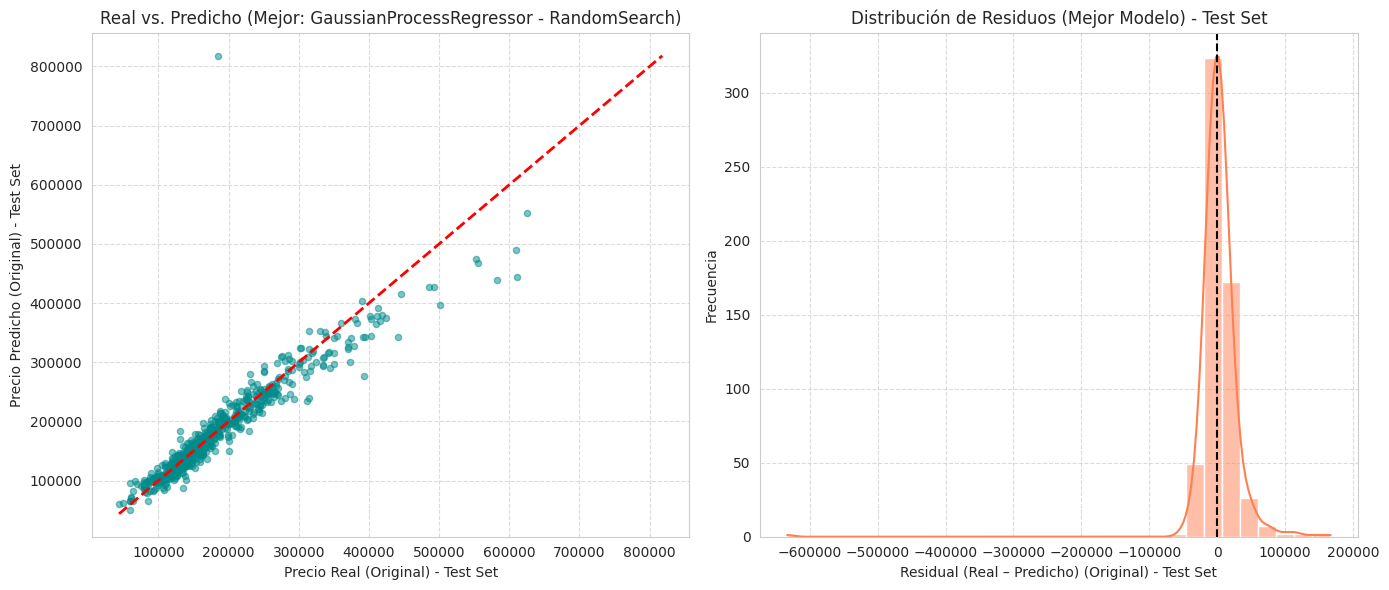


--- Métricas del Mejor Modelo en el CONJUNTO DE PRUEBA (X_test, y_test) ---
  Modelo: GaussianProcessRegressor, Tuneo: RandomSearch
  MAE (log): 0.0843
  MSE (log): 0.0150
  RMSE (log): 0.1224
  R2 (log):  0.9190
  MAPE (orig):8.74%


¡ANÁLISIS EN COLAB COMPLETADO!


In [ ]:
print("\n\n------------------------------------------------------")
print("PARTE 5: PRESENTACIÓN DE RESULTADOS FINALES")
print("------------------------------------------------------")

if all_cv_results_colab:
    df_final_results_colab = pd.DataFrame(all_cv_results_colab)
    # Ordenar por la métrica principal de interés, por ejemplo, MSE en la escala logarítmica
    df_final_results_colab = df_final_results_colab.sort_values(by=['MSE_log_mean'], ascending=True)
    df_final_results_colab.to_csv("ames_cache_colab/df_final_results_colab.csv", index=False)

    print("\nResultados de la Evaluación Cruzada Final (promedios y desviación estándar):")
    print("MAE_log y MSE_log están en la escala logarítmica de SalePrice.")
    print("MAPE_orig está en la escala original de SalePrice (porcentaje).")
    print("R2_log es relativo a la varianza de SalePrice (log). Menor MSE es mejor.")

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000) # Ancho para Colab
    pd.set_option('display.max_colwidth', 120)
    pd.set_option('display.float_format', '{:.4f}'.format)
    print("\nTabla de Resultados (ordenada por mejor MSE_log_mean):")
    display(df_final_results_colab)

    if not df_final_results_colab.empty:
        best_overall_model_config_colab = df_final_results_colab.iloc[0] # El primero después de ordenar
        print("\n--- Mejor Configuración General (basada en menor MSE_log_mean en CV) ---")
        display(pd.DataFrame(best_overall_model_config_colab).T)

        # --- Visualización del Mejor Modelo General en el Conjunto de Prueba ---
        best_model_name = best_overall_model_config_colab['Model']
        best_tuning_method = best_overall_model_config_colab['TuningMethod']
        print(f"\nGenerando gráficos y métricas finales para el mejor modelo en el CONJUNTO DE PRUEBA: {best_model_name} con {best_tuning_method}")

        cached_best = load_from_cache_colab(best_model_name, best_tuning_method)
        final_best_estimator_for_test = None

        if cached_best and 'best_estimator' in cached_best:
            estimator_from_cache = cached_best['best_estimator']
            if hasattr(estimator_from_cache, 'best_estimator_'): # Si es un objeto de búsqueda
                final_best_estimator_for_test = estimator_from_cache.best_estimator_
            else: # Si ya es un pipeline ajustado
                final_best_estimator_for_test = estimator_from_cache

        if final_best_estimator_for_test:
            # Es importante RE-AJUSTAR el mejor pipeline (con sus hiperparámetros ya definidos)
            # con TODOS los datos de X_train antes de evaluar en X_test.
            # El 'final_best_estimator_for_test' cargado del caché ya podría estar ajustado
            # (si se guardó después de .fit() en el tuning o si es el resultado de Optuna).
            # Por seguridad, o si se guardó el pipeline sin ajustar (solo con params), se podría reajustar.
            # Sin embargo, si el caché guardó el resultado de gs_cv o rs_cv (objetos de búsqueda),
            # su .best_estimator_ ya está ajustado con todo X_train.
            # Si es de Optuna y se guardó el pipeline ajustado, también está listo.

            # Para asegurar consistencia, si el caché guardó el objeto de búsqueda,
            # su .best_estimator_ ya fue entrenado en X_train.
            # Si el caché guardó directamente un pipeline (ej. Optuna, o modelo base),
            # este ya fue entrenado en X_train en el paso anterior.
            # No es necesario un .fit() adicional aquí si el caché es consistente.

            try:
                y_pred_test_log = final_best_estimator_for_test.predict(X_test)

                y_test_orig = np.expm1(y_test) # y_test está en log
                y_pred_test_orig = np.expm1(y_pred_test_log)

                plt.figure(figsize=(14, 6))
                plt.subplot(1, 2, 1)
                plt.scatter(y_test_orig, y_pred_test_orig, alpha=0.5, s=20, color='darkcyan')
                min_val = min(y_test_orig.min(), y_pred_test_orig.min())
                max_val = max(y_test_orig.max(), y_pred_test_orig.max())
                plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
                plt.xlabel("Precio Real (Original) - Test Set")
                plt.ylabel("Precio Predicho (Original) - Test Set")
                plt.title(f"Real vs. Predicho (Mejor: {best_model_name} - {best_tuning_method})")
                plt.grid(True, linestyle='--', alpha=0.7)

                plt.subplot(1, 2, 2)
                residuals_orig = y_test_orig - y_pred_test_orig
                sns.histplot(residuals_orig, kde=True, bins=30, color='coral')
                plt.axvline(0, color='black', ls='--', lw=1.5)
                plt.xlabel("Residual (Real – Predicho) (Original) - Test Set")
                plt.ylabel("Frecuencia")
                plt.title("Distribución de Residuos (Mejor Modelo) - Test Set")
                plt.grid(True, linestyle='--', alpha=0.7)

                plt.tight_layout()
                plt.show()

                final_mae_test_log = mean_absolute_error(y_test, y_pred_test_log)
                final_mse_test_log = mean_squared_error(y_test, y_pred_test_log)
                final_r2_test_log = r2_score(y_test, y_pred_test_log)
                final_mape_test_orig = mean_absolute_percentage_error_custom(y_test_orig, y_pred_test_orig)

                print("\n--- Métricas del Mejor Modelo en el CONJUNTO DE PRUEBA (X_test, y_test) ---")
                print(f"  Modelo: {best_model_name}, Tuneo: {best_tuning_method}")
                print(f"  MAE (log): {final_mae_test_log:.4f}")
                print(f"  MSE (log): {final_mse_test_log:.4f}")
                print(f"  RMSE (log): {np.sqrt(final_mse_test_log):.4f}") # RMSE es interpretable
                print(f"  R2 (log):  {final_r2_test_log:.4f}")
                print(f"  MAPE (orig):{final_mape_test_orig:.2f}%")
            except Exception as e_test_eval:
                 print(f"Error durante la evaluación en el conjunto de prueba del mejor modelo: {e_test_eval}")
        else:
            print(f"No se pudo cargar/reconstruir el mejor estimador ({best_model_name} - {best_tuning_method}) desde el caché para evaluación en test set.")
    else:
        print("La tabla de resultados está vacía. No se puede determinar el mejor modelo.")
else:
    print("No se generaron resultados finales. Revisa los pasos anteriores.")

print("\n\n======================================================")
print("¡ANÁLISIS EN COLAB COMPLETADO!")
print("======================================================")

# PARTE 6: Dashboard en streamlit para presentar los resultados

#instalación de librerías

In [ ]:
!pip install streamlit -q
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -q
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared

# Crear carpeta pages para trabajar varias paginas en Streamlit, a saber la Bienvenida, EDA, y la comparación de modelos

In [ ]:
!mkdir pages

# Dashboard

In [ ]:
%%bash
# 1) Creamos la carpeta de páginas
mkdir -p pages

# 2) Archivo raíz
cat << 'EOF' > 0_👋_Hello.py
import streamlit as st

st.set_page_config(page_title="Bienvenida", page_icon="👋")
st.sidebar.success("Selecciona una sección")
st.write("# Bienvenido al Dashboard del Primer Parcial de Teoría Aprendizaje de Máquina 2025 - Caso Ames Housing")
st.markdown("Este panel te permite explorar los datos (EDA) y comparar los tres mejores regresores.")
EOF

# 3) Página de EDA
cat << 'EOF' > pages/1_EDA.py
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="EDA", page_icon="🔍")
st.title("Análisis Exploratorio de Datos")

@st.cache_data
def load_data():
    return pd.read_csv("AmesHousing.csv")

df = load_data()

st.subheader("Primeras 5 filas")
st.dataframe(df.head())

st.subheader("Estadísticas Descriptivas")
st.write(df.describe())

if st.checkbox("Mostrar histograma de SalePrice"):
    fig, ax = plt.subplots()
    sns.histplot(df["SalePrice"], kde=True, ax=ax)
    st.pyplot(fig)

if st.checkbox("Matriz de correlación"):
    corr = df.select_dtypes("number").corr()
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
    st.pyplot(fig)
EOF

# 4) Página de comparación de modelos
cat << 'EOF' > pages/2_Model_Comparison.py
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

st.set_page_config(page_title="Comparación Modelos", page_icon="📊")
st.title("Comparación de los 3 Mejores Regresores")

@st.cache_data
def load_results():
    return pd.read_csv("ames_cache_colab/df_final_results_colab.csv")

df = load_results()

st.subheader("Resultados de todos los modelos")
st.dataframe(df)

# Seleccionamos por MSE_log_mean (menor es mejor)
top3 = df.nsmallest(3, "MSE_log_mean")
st.subheader("Top 3 Modelos")
st.table(top3[["Model","TuningMethod","MAE_log_mean","MSE_log_mean","R2_log_mean","MAPE_orig_mean"]])

métrica = st.selectbox("Elige métrica para graficar",
                       ["MAE_log_mean","MSE_log_mean","R2_log_mean","MAPE_orig_mean"])
fig, ax = plt.subplots()
sns.barplot(data=top3, x="Model", y=métrica, ax=ax)
ax.set_title(f"{métrica} de los Top 3")
st.pyplot(fig)
EOF

## Inicialización del Dashboard a partir de túnel local
Reemplazar nombre de archivo: Reemplaza el nombre del archivo como se indica en el comentario de la linea 6 de la celda de codigo

Accede al enlace provisional: Una vez que la aplicación esté corriendo, LocalTunnel generará un enlace temporal. Haz clic o copia ese enlace para acceder a tu aplicación en el navegador (cada vez que corras la celda, el link podrá ser diferente).

Nota: Para finalizar la ejecución del Dashboard ejecuta la ultima celda de codigo y sigue las instrucciones.

In [ ]:
# 1. Arranca Streamlit en background
!nohup streamlit run 0_👋_Hello.py --server.port 8501 &> streamlit.log &

# 2. Arranca cloudflared y vuelca sus logs
!nohup cloudflared tunnel --url http://localhost:8501 &> cloudflared.log &

# 3. Espera un par de segundos y mira las últimas líneas
# 1. Arranca Streamlit en background
!nohup streamlit run 0_👋_Hello.py --server.port 8501 &> streamlit.log &

# 2. Arranca cloudflared y vuelca sus logs
!nohup cloudflared tunnel --url http://localhost:8501 &> cloudflared.log &

# 3. Espera un par de segundos y mira las últimas líneas
!sleep 5
!tail -n 20 cloudflared.log

2025-05-16T23:45:27Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-05-16T23:45:27Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-05-16T23:45:31Z INF +--------------------------------------------------------------------------------------------+
2025-05-16T23:45:31Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-05-16T23:45:31Z INF |  https://refuse-rebate-marilyn-margin.trycloudflare.co

In [ ]:
!tail -n 30 cloudflared.log


2025-05-16T21:59:21Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-05-16T21:59:21Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-05-16T21:59:25Z INF +--------------------------------------------------------------------------------------------+
2025-05-16T21:59:25Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-05-16T21:59:25Z INF |  https://merit-reno-buying-dakota.trycloudflare.com   

In [ ]:
from google.colab import files

# Si tu archivo realmente se llama “df_final_results_colab.csv”:
files.download('ames_cache_colab/df_final_results_colab.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>